In [197]:

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import os as os
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [198]:
warnings.filterwarnings("ignore")
os.chdir('/Users/sherry/Documents/MGTF 495 Current Topic/Group Project /Group Project data')
df = pd.read_excel('France.xlsx')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df.set_index('Date', inplace=True)

# Strip whitespace from column names
df.columns = df.columns.str.strip()
# Verify the changes
print("Columns after stripping whitespace:", df.columns.tolist())

event_periods = {
    '2000': [('2000-04-10', '2000-05-03'), ('2000-08-07', '2000-08-30'), ('2000-11-03', '2000-11-26')],
    '2001': [('2001-01-09', '2001-02-01'), ('2001-05-15', '2001-06-09'), ('2001-09-05', '2001-09-29')],
    '2002': [('2002-02-13', '2002-03-06'), ('2002-06-12', '2002-07-05'), ('2002-10-03', '2002-10-26')],
    '2003': [('2003-03-14', '2003-04-07'), ('2003-07-07', '2003-07-31'), ('2003-11-09', '2003-12-02')],
    '2004': [('2004-02-16', '2004-03-09'), ('2004-06-14', '2004-07-07'), ('2004-10-14', '2004-11-04')],
    '2005': [('2005-01-14', '2005-02-07'), ('2005-05-03', '2005-05-27'), ('2005-09-01', '2005-09-22')],
    '2006': [('2006-03-02', '2006-03-25'), ('2006-07-05', '2006-07-29'), ('2006-11-05', '2006-11-28')],
    '2007': [('2007-01-13', '2007-02-01'), ('2007-05-24', '2007-06-14'), ('2007-09-06', '2007-09-29')],
    '2008': [('2008-03-04', '2008-03-27'), ('2008-07-15', '2008-08-08'), ('2008-11-24', '2008-12-13')],
    '2009': [('2009-01-11', '2009-02-01'), ('2009-05-06', '2009-05-30'), ('2009-09-07', '2009-09-29')],
    '2010': [('2010-04-18', '2010-05-11'), ('2010-08-20', '2010-09-12'), ('2010-12-10', '2010-12-30')],
    '2011': [('2011-03-30', '2011-04-23'), ('2011-08-02', '2011-08-26'), ('2011-11-24', '2011-12-13')],
    '2012': [('2012-03-12', '2012-04-04'), ('2012-07-14', '2012-08-07'), ('2012-11-06', '2012-11-26')],
    '2013': [('2013-02-23', '2013-03-17'), ('2013-06-26', '2013-07-20'), ('2013-10-21', '2013-11-10')],
    '2014': [('2014-02-06', '2014-02-11'), ('2014-06-07', '2014-07-01'), ('2014-10-04', '2014-10-25')],
    '2015': [('2015-01-21', '2015-02-11'), ('2015-05-18', '2015-06-11'), ('2015-09-17', '2015-10-09')],
    '2016': [('2016-01-05', '2016-01-25'), ('2016-04-28', '2016-05-22'), ('2016-08-30', '2016-09-22')],
    '2017': [('2017-04-09', '2017-05-03'), ('2017-08-12', '2017-09-05'), ('2017-12-03', '2017-12-22')],
    '2018': [('2018-03-22', '2018-04-15'), ('2018-07-26', '2018-08-18'), ('2018-11-16', '2018-12-06')],
    '2019': [('2019-03-05', '2019-03-28'), ('2019-07-07', '2019-07-31'), ('2019-10-31', '2019-11-20')],
    '2020': [('2020-02-16', '2020-03-09'), ('2020-06-17', '2020-07-12'), ('2020-10-13', '2020-11-03')],
    '2021': [('2021-01-30', '2021-02-20'), ('2021-05-29', '2021-06-22'), ('2021-09-27', '2021-10-18')],
    '2022': [('2022-01-14', '2022-02-03'), ('2022-05-10', '2022-06-02'), ('2022-09-09', '2022-10-02')],
    '2023': [('2023-04-21', '2023-05-14'), ('2023-08-23', '2023-09-15'), ('2023-12-13', '2024-01-01')]
}


Columns after stripping whitespace: ['Return']


In [199]:
# Convert event periods to DateTime objects
for year in event_periods:
    event_periods[year] = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in event_periods[year]]

dummy_significance = []
# Loop through each year and perform regression separately
for year, periods in event_periods.items():
    # Filter data for the current year using DateTimeIndex
    year_data = df[df.index.year == int(year)].copy()

    # Create the dummy variable for each event period
    year_data['Dummy'] = 0  # Start by setting all dummy values to 0

    # Mark the dates within the event periods as 1 in the dummy column
    for start_date, end_date in periods:
        year_data.loc[(year_data.index >= start_date) & (year_data.index <= end_date), 'Dummy'] = 1

    # Lag the return by one period (shift)
    year_data['Lag_Return'] = year_data['Return'].shift(1)

    # Drop missing values created by lagging
    year_data = year_data.dropna()

    # Fit an ARMA(1, 1) model using previous year's return data
    arma_model = ARIMA(year_data['Return'], order=(1, 0, 0))  # ARMA(1, 1)
    arma_model_fit = arma_model.fit()
    print(f"ARMA(1, 1) model fit for {int(year) - 1}")

    # Step 2: Extract the residuals from the ARIMA model
    year_data['ARIMA_Residuals'] = arma_model_fit.resid 
    
    # Step 3: Define the independent variables: Lagged return, Dummy, and ARIMA residuals
    X = year_data[['Lag_Return', 'Dummy', 'ARIMA_Residuals']]
    X = sm.add_constant(X)  # Add constant for intercept

    # Dependent variable: Return
    y = year_data['Return']

    # Step 4: Perform the regression (OLS)
    model = sm.OLS(y, X).fit()

    # Print the summary of the regression for the current year
    print(f"Regression Results for {year}:\n")
    print(model.summary())
    print("\n" + "="*80 + "\n")
    
    # Step 5: Check if the p-value for 'Dummy' is below 0.05 (significant)
    dummy_p_value = model.pvalues['Dummy']
    if dummy_p_value < 0.15:
        dummy_significance.append(1)  # Significant
    else:
        dummy_significance.append(0)  # Not significant

# Calculate the percentage of significance for the dummy variable
percentage_significance = (sum(dummy_significance) / len(dummy_significance)) * 100
print(f"Percentage of years with significant 'Dummy' variable: {percentage_significance:.2f}%")


ARMA(1, 1) model fit for 1999
Regression Results for 2000:

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.366e+07
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:47:42   Log-Likelihood:                 2468.7
No. Observations:                 252   AIC:                            -4929.
Df Residuals:                     248   BIC:                            -4915.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

##Dummy Varibale regression

In [200]:

# Convert event periods to DateTime objects
for year in event_periods:
    event_periods[year] = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in event_periods[year]]

dummy_significance = []
# Loop through each year and perform regression separately
for year, periods in event_periods.items():
    # Filter data for the current year using DateTimeIndex
    year_data = df[df.index.year == int(year)].copy()

    # Create the dummy variable for each event period
    year_data['Dummy'] = 0  # Start by setting all dummy values to 0

    # Mark the dates within the event periods as 1 in the dummy column
    for start_date, end_date in periods:
        year_data.loc[(year_data.index >= start_date) & (year_data.index <= end_date), 'Dummy'] = 1

    # Lag the return by one period (shift)
    year_data['Lag_Return'] = year_data['Return'].shift(1)

    # Drop missing values created by lagging
    year_data = year_data.dropna()

    # Find the best ARIMA model parameters using auto_arima
    auto_model = auto_arima(year_data['Return'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    best_order = auto_model.order
    print(f"Best ARIMA order for {year}: {best_order}")
    
    # Fit ARIMA model with the selected best order
    best_arma_model = auto_model.fit(year_data['Return'])
    year_data['Normal_Return'] = best_arma_model.predict_in_sample()

    # Step 2: Extract the residuals from the ARIMA model
    year_data['ARIMA_Residuals'] = best_arma_model.resid 

    # Step 3: Define the independent variables: Lagged return, Dummy, and ARIMA residuals
    X = year_data[['Lag_Return', 'Dummy', 'ARIMA_Residuals']]
    X = sm.add_constant(X)  # Add constant for intercept

    # Dependent variable: Return
    y = year_data['Return']

    # Step 4: Perform the regression (OLS)
    model = sm.OLS(y, X).fit()

    # Print the summary of the regression for the current year
    print(f"Regression Results for {year}:\n")
    print(model.summary())
    print("\n" + "="*80 + "\n")
    
    # Step 5: Check if the p-value for 'Dummy' is below 0.05 (significant)
    dummy_p_value = model.pvalues['Dummy']
    if dummy_p_value < 0.15:
        dummy_significance.append(1)  # Significant
    else:
        dummy_significance.append(0)  # Not significant

# Calculate the percentage of significance for the dummy variable
percentage_significance = (sum(dummy_significance) / len(dummy_significance)) * 100
print(f"Percentage of years with significant 'Dummy' variable: {percentage_significance:.2f}%")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1445.776, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1450.758, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1449.383, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1449.181, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1447.400, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1448.803, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
Best ARIMA order for 2000: (0, 0, 0)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

CAR

In [201]:
def calculate_abnormal_returns_and_compare_variance(df, event_periods, significance_level=0.025):
    abnormal_returns = {}
    significant_years_count = 0
    total_years = len(event_periods)

    # Loop through each year
    for year, periods in event_periods.items():
        yearly_data = df[df.index.year == int(year)].copy()
        
        # Check for missing values
        if yearly_data['Return'].isnull().any():
            print(f"Missing values detected in {year}, consider handling them before fitting the model.")
            continue

        # Find the best ARIMA model parameters using auto_arima
        auto_model = auto_arima(yearly_data['Return'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        best_order = auto_model.order
        print(f"Best ARIMA order for {year}: {best_order}")

        # Fit ARIMA model with the selected best order
        best_arma_model = auto_model.fit(yearly_data['Return'])
        yearly_data['Normal_Return'] = best_arma_model.predict_in_sample()

        # Initialize lists to accumulate event and non-event variances
        event_returns = []
        non_event_returns = yearly_data['Return'].tolist()
        year_significant = False  # Flag to track significance in the year

        # Loop through each event period
        for start_date, end_date in periods:
            event_window = yearly_data[start_date:end_date].copy()
            event_window['Abnormal_Return'] = event_window['Return'] - event_window['Normal_Return']
            event_window['CAR'] = event_window['Abnormal_Return'].cumsum()
            
            # Collect event returns and remove from non-event data
            event_returns.extend(event_window['Return'].tolist())
            non_event_returns = [ret for ret, date in zip(non_event_returns, yearly_data.index) if date not in event_window.index]
            
            # Store abnormal returns and CAR for the event period
            abnormal_returns[(year, start_date, end_date)] = event_window[['Return', 'Normal_Return', 'Abnormal_Return', 'CAR']]
            
            # Test significance (t-test of CAR against 0)
            t_stat, car_p_value = stats.ttest_1samp(event_window['CAR'], 0)
            if car_p_value < significance_level:
                year_significant = True  # Mark year as significant if any period is significant
                break  # No need to check other periods in the year

        # Update count if the year had any significant event period
        if year_significant:
            significant_years_count += 1

        # Calculate variances of event and non-event returns
        event_variance = pd.Series(event_returns).var()
        non_event_variance = pd.Series(non_event_returns).var()
        variance_difference = event_variance - non_event_variance
        
        # Conduct F-test to compare variances
        f_stat = event_variance / non_event_variance
        df1, df2 = len(event_returns) - 1, len(non_event_returns) - 1
        p_value = stats.f.cdf(f_stat, df1, df2)
        
        print(f"\n{year} Variance Comparison")
        print(f"Event Variance: {event_variance:.4f}, Non-Event Variance: {non_event_variance:.4f}")
        print(f"Variance Difference (Event - Non-Event): {variance_difference:.4f}")
        print(f"F-Statistic for Variance Comparison: {f_stat:.4f}, Variance P-Value: {p_value:.4f}\n")

    # Calculate and output the percentage of years with significant abnormal returns
    percentage_significant_years = (significant_years_count / total_years) * 100
    print(f"Percentage of years with significant abnormal returns: {percentage_significant_years:.2f}%")
    return abnormal_returns, percentage_significant_years

# Execute the function
abnormal_returns, percentage_significant_years = calculate_abnormal_returns_and_compare_variance(df, event_periods)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1452.620, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1457.423, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1456.127, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1456.156, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1453.440, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1455.459, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.259 seconds
Best ARIMA order for 2000: (0, 0, 0)

2000 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.7385, Variance P-Value: 0.1537

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1446.935, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1445.335, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1443.553, Time=0.02 sec


In [202]:
from scipy.stats import levene
variance_significance = []
for year, periods in event_periods.items():
    year_data = df[df.index.year == int(year)].copy()
    year_data['Dummy'] = 0
    for start_date, end_date in periods:
        year_data.loc[(year_data.index >= start_date) & (year_data.index <= end_date), 'Dummy'] = 1
    event_data = year_data[year_data['Dummy'] == 1]['Return']
    non_event_data = year_data[year_data['Dummy'] == 0]['Return']
    stat, p_value = levene(event_data, non_event_data)
    if p_value < 0.05:
        variance_significance.append(1)  
    else:
        variance_significance.append(0)  
        
percentage_variance_significance = (sum(variance_significance) / len(variance_significance)) * 100
print(f"Percentage of years with significant variance difference: {percentage_variance_significance:.2f}%")


Percentage of years with significant variance difference: 20.83%


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1452.620, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1457.423, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1456.127, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1456.156, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1453.440, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1455.459, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.248 seconds
Best ARIMA order for 2000: (0, 0, 0)


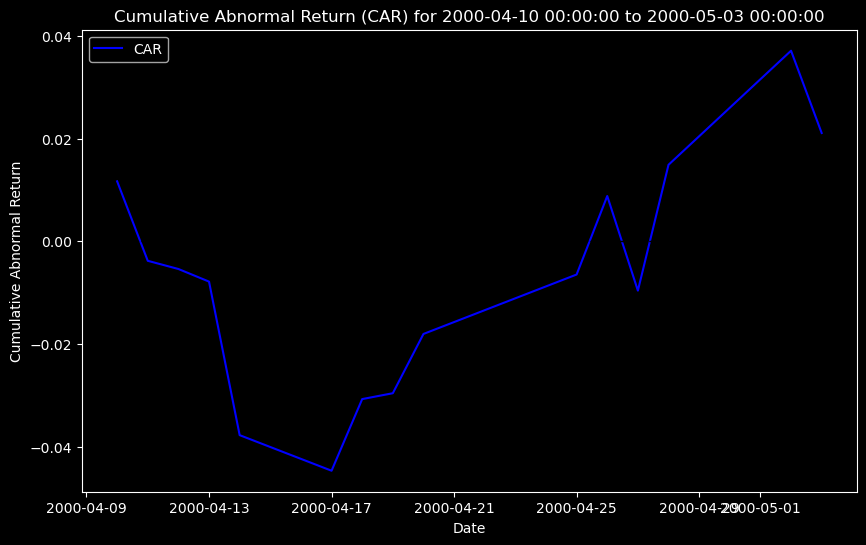


2000 Event: 2000-04-10 00:00:00 to 2000-05-03 00:00:00
Mean CAR: -0.0067, Std Dev: 0.0230
T-Statistic: -1.1259, CAR P-Value: 0.2791


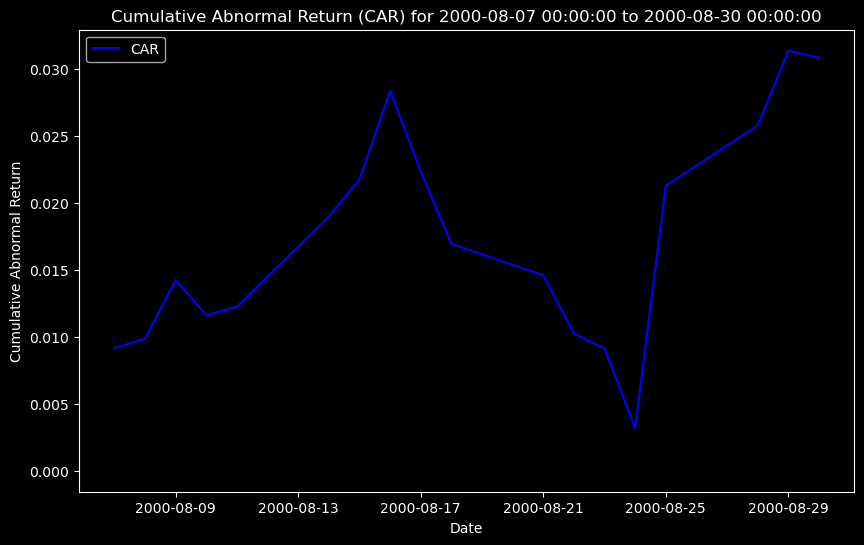


2000 Event: 2000-08-07 00:00:00 to 2000-08-30 00:00:00
Mean CAR: 0.0173, Std Dev: 0.0082
T-Statistic: 8.9348, CAR P-Value: 0.0000


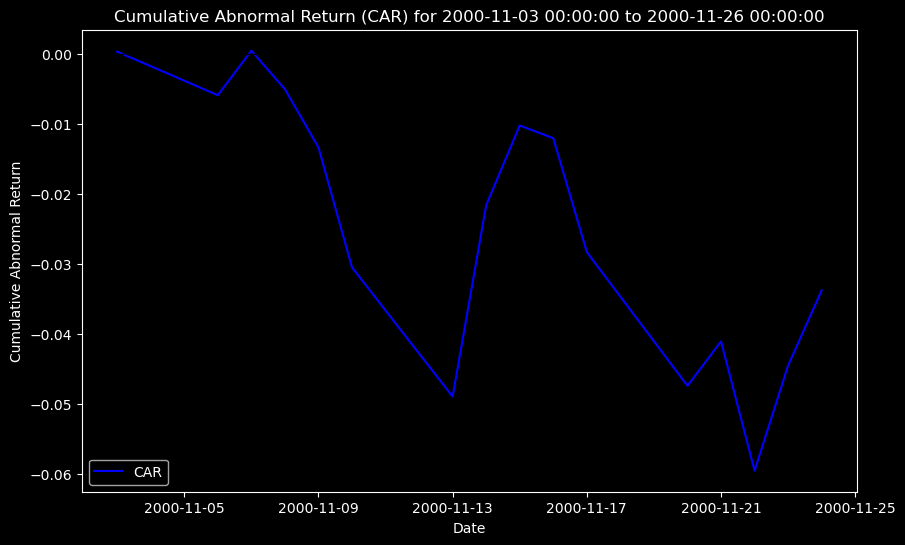


2000 Event: 2000-11-03 00:00:00 to 2000-11-26 00:00:00
Mean CAR: -0.0251, Std Dev: 0.0193
T-Statistic: -5.1973, CAR P-Value: 0.0001

2000 Variance Comparison
Event Variance: 0.0002, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.8467, Variance P-Value: 0.2501

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1446.935, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1445.335, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1443.553, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1443.624, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1443.205, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1443.878, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1447.935, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1442.516, Time=0.08 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-1440.332, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0] 

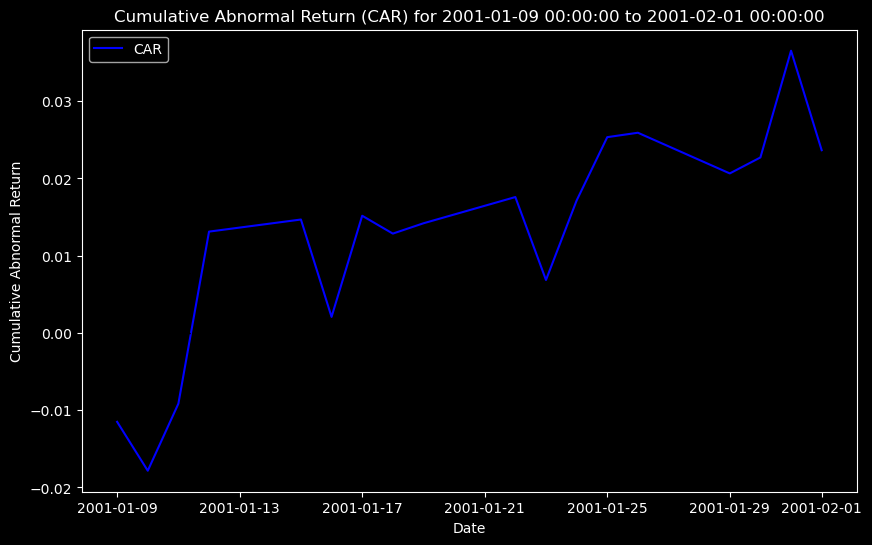


2001 Event: 2001-01-09 00:00:00 to 2001-02-01 00:00:00
Mean CAR: 0.0128, Std Dev: 0.0141
T-Statistic: 3.8437, CAR P-Value: 0.0013


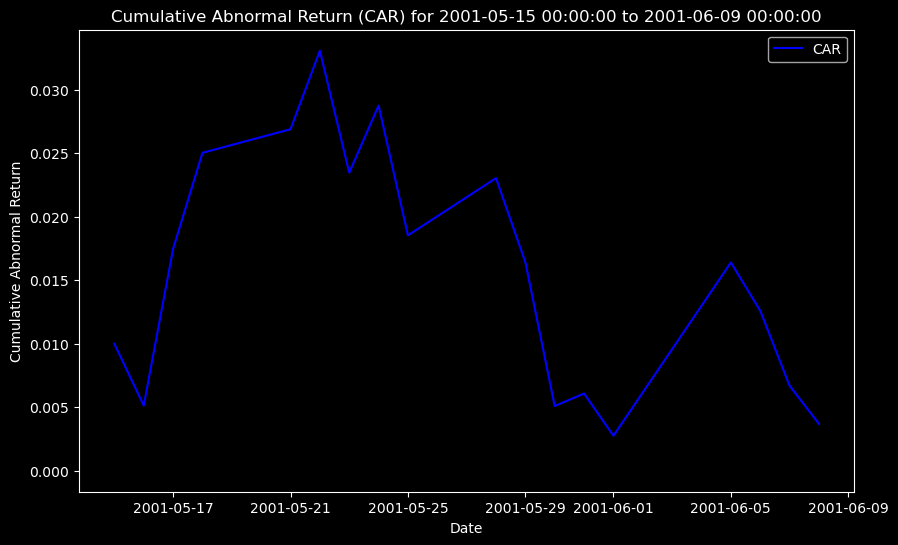


2001 Event: 2001-05-15 00:00:00 to 2001-06-09 00:00:00
Mean CAR: 0.0156, Std Dev: 0.0096
T-Statistic: 6.9112, CAR P-Value: 0.0000


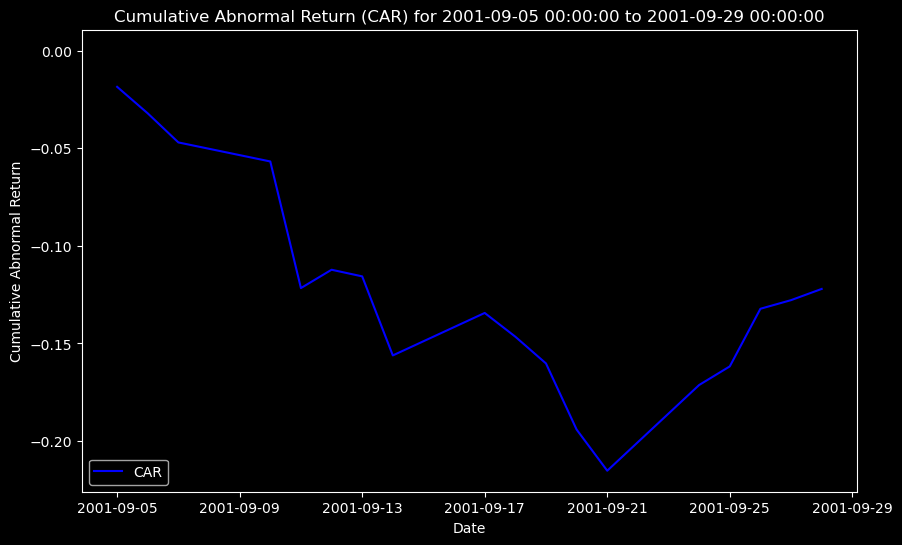


2001 Event: 2001-09-05 00:00:00 to 2001-09-29 00:00:00
Mean CAR: -0.1236, Std Dev: 0.0543
T-Statistic: -9.6549, CAR P-Value: 0.0000

2001 Variance Comparison
Event Variance: 0.0003, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): 0.0001
F-Statistic for Variance Comparison: 1.3730, Variance P-Value: 0.9371

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1308.918, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1314.764, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1312.791, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1312.793, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1310.764, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1313.771, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
Best ARIMA order for 2002: (0, 0, 0)


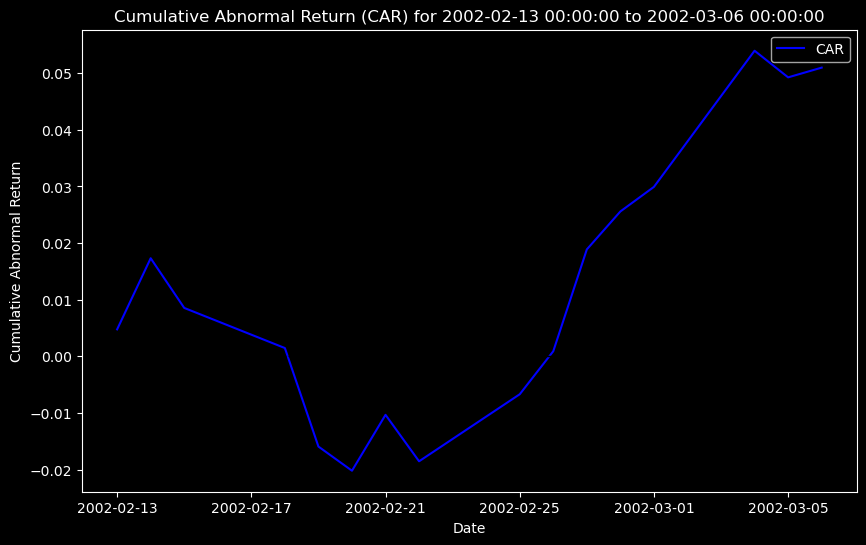


2002 Event: 2002-02-13 00:00:00 to 2002-03-06 00:00:00
Mean CAR: 0.0119, Std Dev: 0.0247
T-Statistic: 1.9220, CAR P-Value: 0.0738


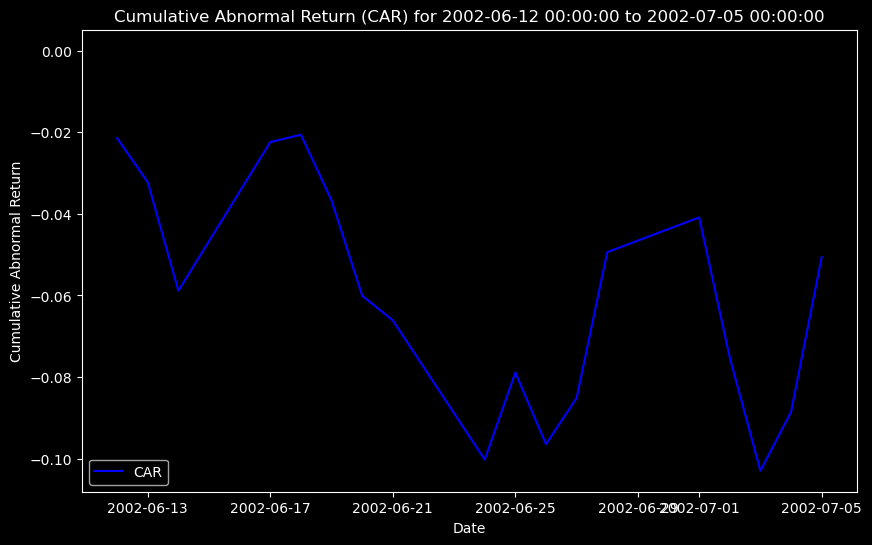


2002 Event: 2002-06-12 00:00:00 to 2002-07-05 00:00:00
Mean CAR: -0.0604, Std Dev: 0.0279
T-Statistic: -9.1903, CAR P-Value: 0.0000


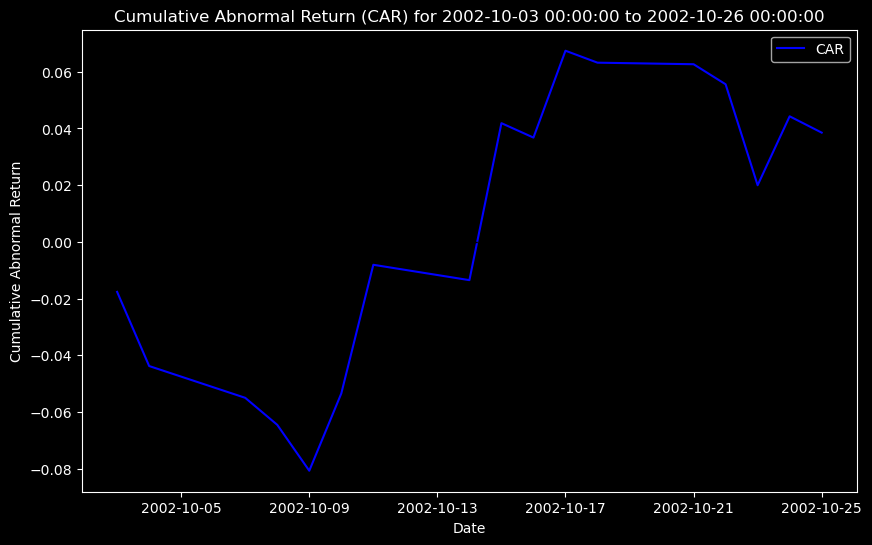


2002 Event: 2002-10-03 00:00:00 to 2002-10-26 00:00:00
Mean CAR: 0.0055, Std Dev: 0.0507
T-Statistic: 0.4478, CAR P-Value: 0.6603

2002 Variance Comparison
Event Variance: 0.0005, Non-Event Variance: 0.0003
Variance Difference (Event - Non-Event): 0.0002
F-Statistic for Variance Comparison: 1.5107, Variance P-Value: 0.9751

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1471.295, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1480.517, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1478.702, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1478.698, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1476.480, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1479.359, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.220 seconds
Best ARIMA order for 2003: (0, 0, 0)


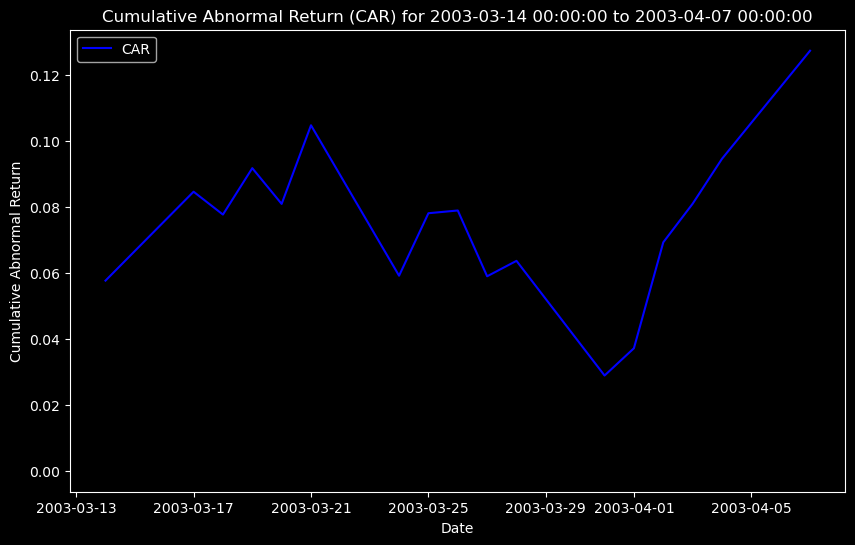


2003 Event: 2003-03-14 00:00:00 to 2003-04-07 00:00:00
Mean CAR: 0.0749, Std Dev: 0.0237
T-Statistic: 13.0161, CAR P-Value: 0.0000


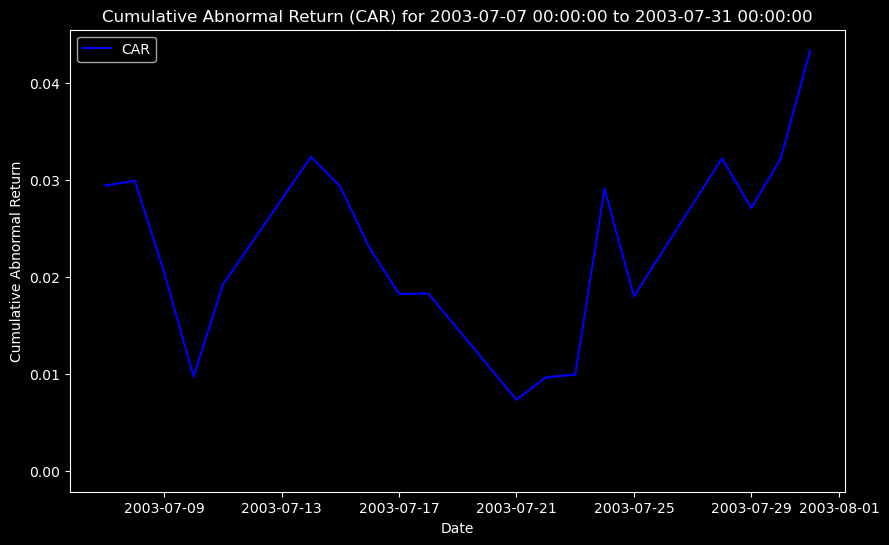


2003 Event: 2003-07-07 00:00:00 to 2003-07-31 00:00:00
Mean CAR: 0.0231, Std Dev: 0.0098
T-Statistic: 10.3018, CAR P-Value: 0.0000


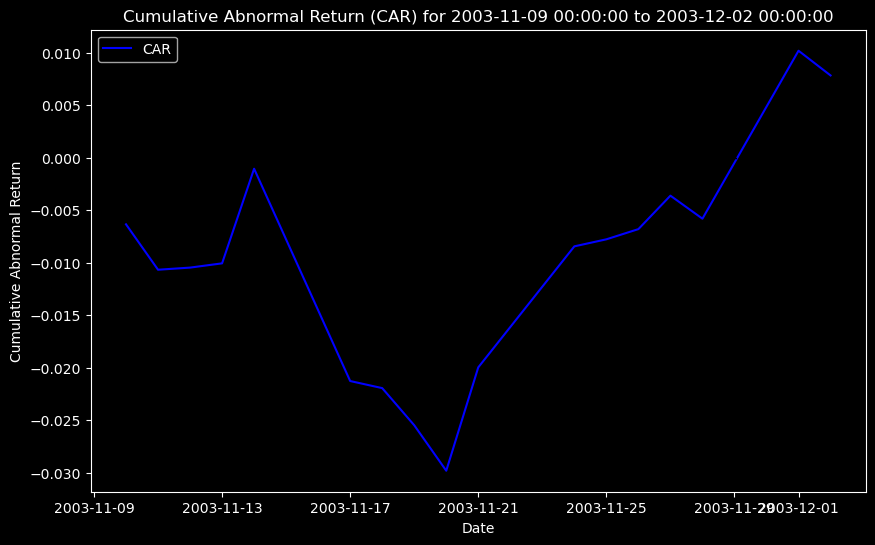


2003 Event: 2003-11-09 00:00:00 to 2003-12-02 00:00:00
Mean CAR: -0.0101, Std Dev: 0.0109
T-Statistic: -3.8161, CAR P-Value: 0.0015

2003 Variance Comparison
Event Variance: 0.0003, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): 0.0001
F-Statistic for Variance Comparison: 1.9152, Variance P-Value: 0.9993

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1801.633, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1803.344, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1805.413, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1804.898, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1804.842, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1804.377, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1802.669, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1804.981, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.289 seconds
Best ARIMA orde

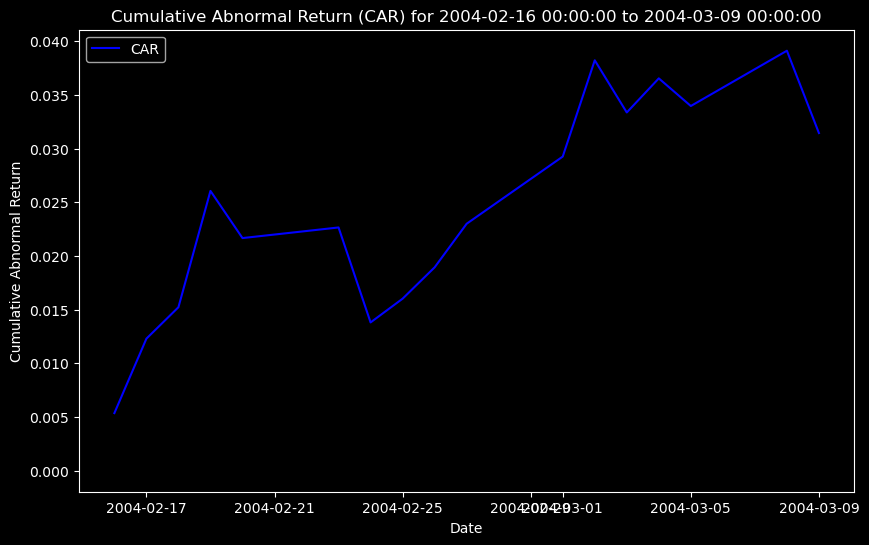


2004 Event: 2004-02-16 00:00:00 to 2004-03-09 00:00:00
Mean CAR: 0.0245, Std Dev: 0.0101
T-Statistic: 10.0498, CAR P-Value: 0.0000


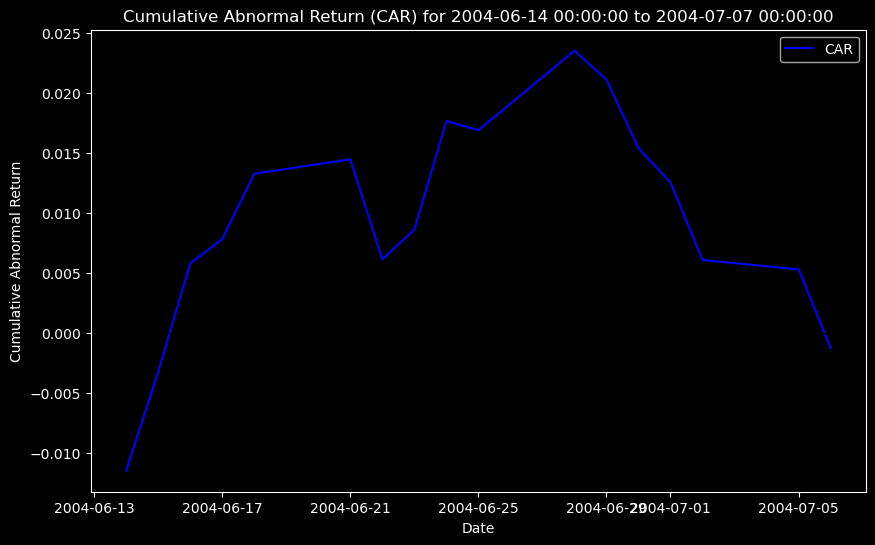


2004 Event: 2004-06-14 00:00:00 to 2004-07-07 00:00:00
Mean CAR: 0.0094, Std Dev: 0.0090
T-Statistic: 4.2631, CAR P-Value: 0.0006


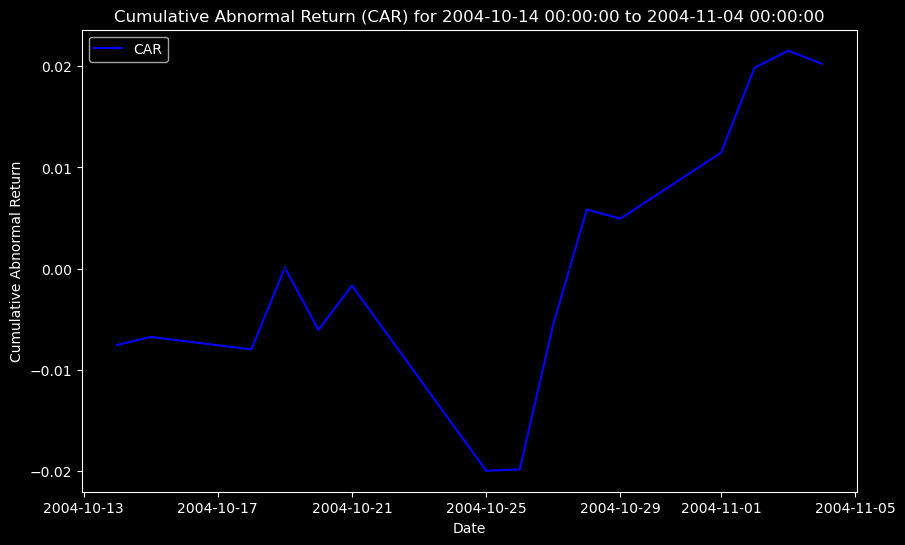


2004 Event: 2004-10-14 00:00:00 to 2004-11-04 00:00:00
Mean CAR: 0.0006, Std Dev: 0.0133
T-Statistic: 0.1704, CAR P-Value: 0.8671

2004 Variance Comparison
Event Variance: 0.0000, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.8174, Variance P-Value: 0.2055

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1850.541, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1855.124, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1853.609, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1853.688, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1851.384, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1859.343, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1857.440, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1857.468, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1855.168, Time=0.03 sec

Best model:  ARIMA(0,0,0)

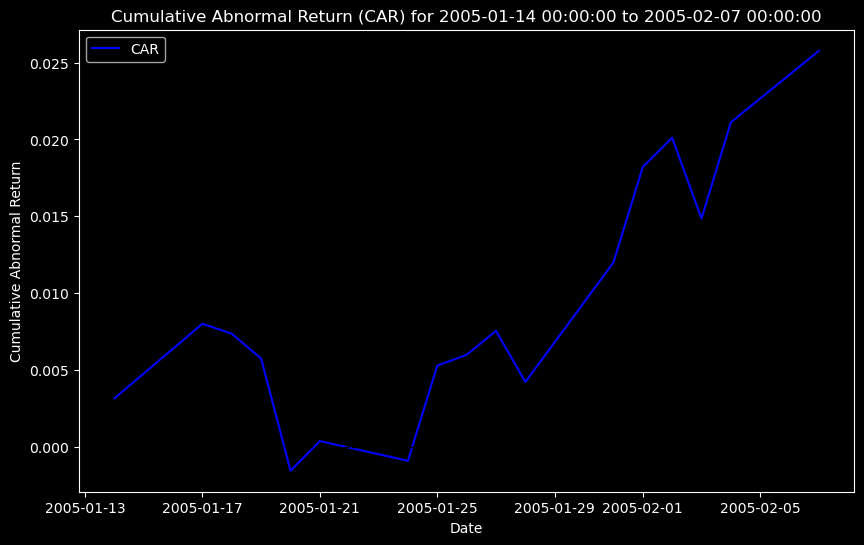


2005 Event: 2005-01-14 00:00:00 to 2005-02-07 00:00:00
Mean CAR: 0.0092, Std Dev: 0.0081
T-Statistic: 4.6874, CAR P-Value: 0.0002


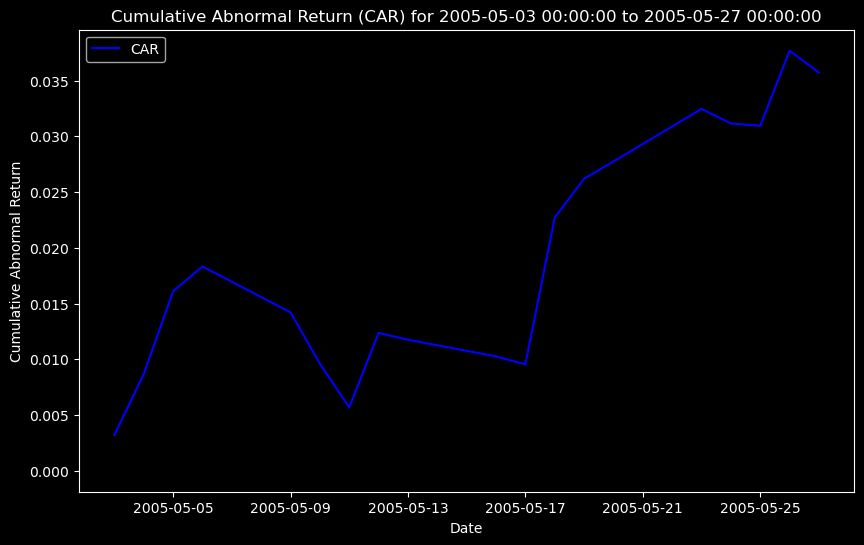


2005 Event: 2005-05-03 00:00:00 to 2005-05-27 00:00:00
Mean CAR: 0.0192, Std Dev: 0.0110
T-Statistic: 7.6332, CAR P-Value: 0.0000


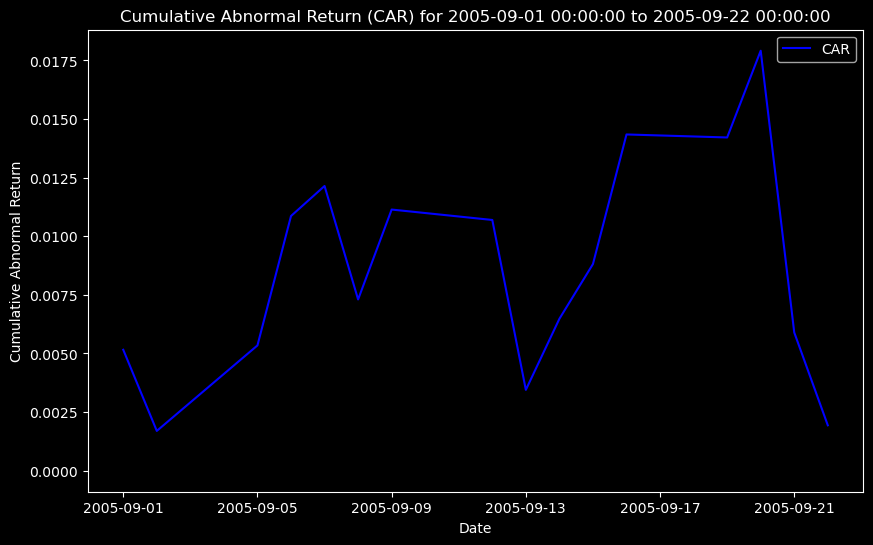


2005 Event: 2005-09-01 00:00:00 to 2005-09-22 00:00:00
Mean CAR: 0.0086, Std Dev: 0.0047
T-Statistic: 7.2761, CAR P-Value: 0.0000

2005 Variance Comparison
Event Variance: 0.0000, Non-Event Variance: 0.0000
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.6201, Variance P-Value: 0.0227

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1721.841, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1724.637, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1723.392, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1723.274, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1719.009, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1725.249, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1724.320, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1724.245, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1720.740, Time=0.06 sec

Best model:  ARIMA(0,0,0)

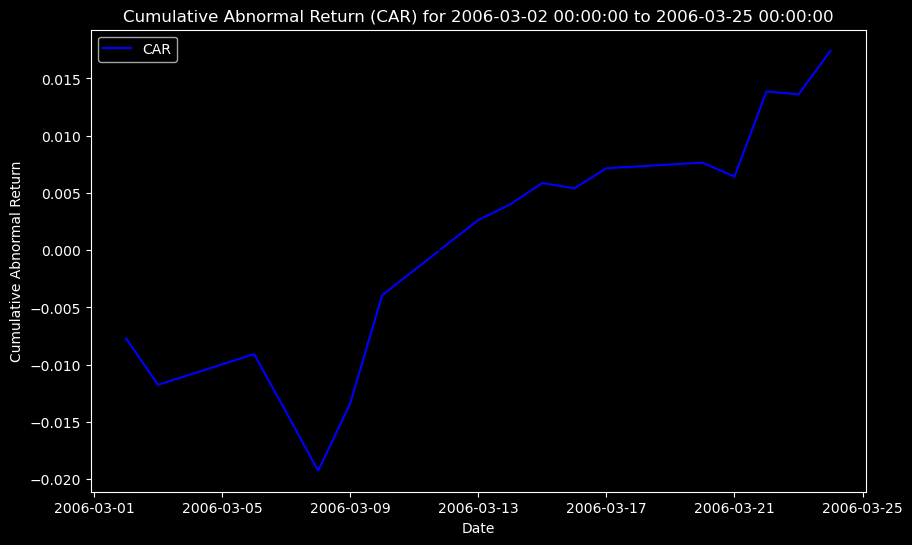


2006 Event: 2006-03-02 00:00:00 to 2006-03-25 00:00:00
Mean CAR: 0.0003, Std Dev: 0.0111
T-Statistic: 0.1050, CAR P-Value: 0.9177


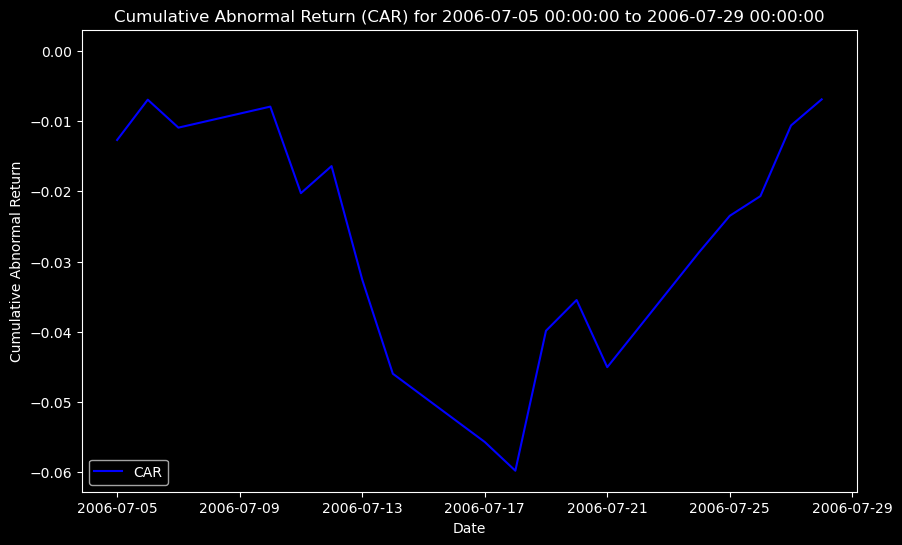


2006 Event: 2006-07-05 00:00:00 to 2006-07-29 00:00:00
Mean CAR: -0.0267, Std Dev: 0.0171
T-Statistic: -6.6260, CAR P-Value: 0.0000


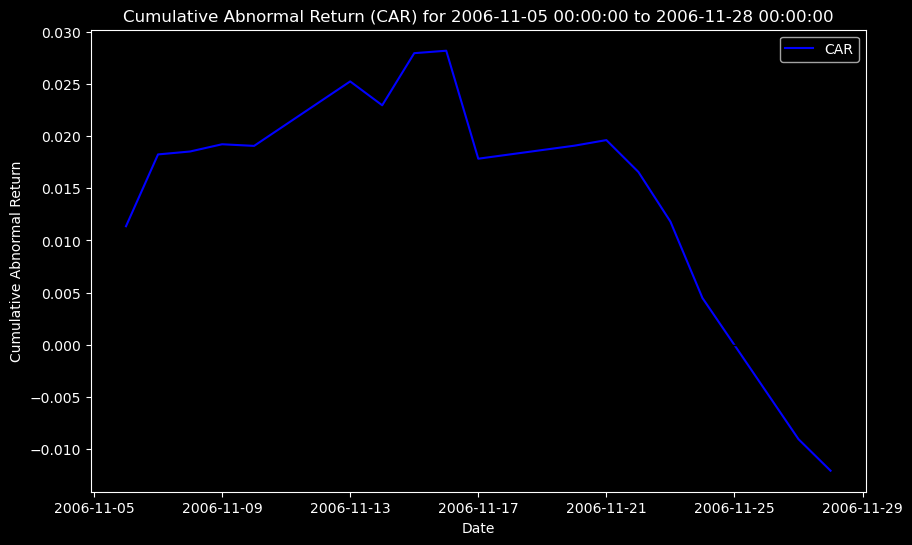


2006 Event: 2006-11-05 00:00:00 to 2006-11-28 00:00:00
Mean CAR: 0.0152, Std Dev: 0.0114
T-Statistic: 5.5354, CAR P-Value: 0.0000

2006 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.7925, Variance P-Value: 0.1628

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1662.644, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1670.644, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1668.646, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1668.646, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1666.646, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1668.820, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.246 seconds
Best ARIMA order for 2007: (0, 0, 0)


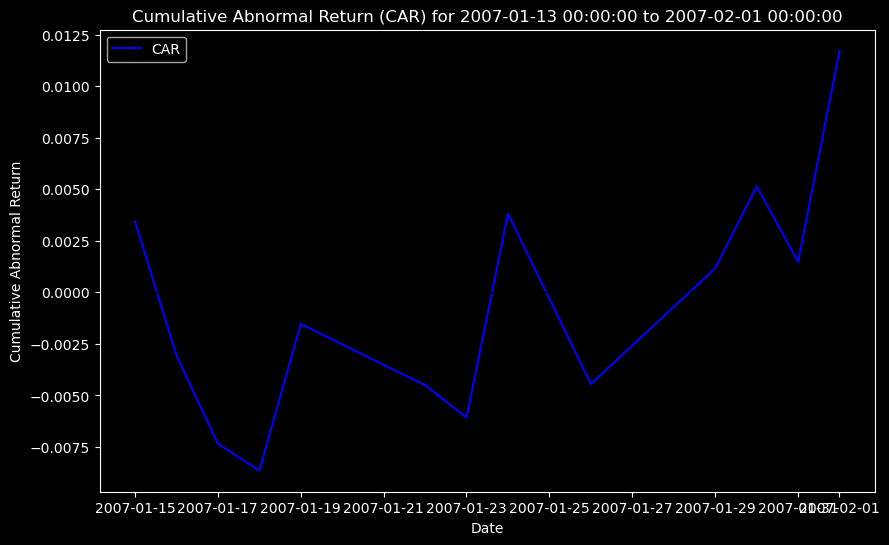


2007 Event: 2007-01-13 00:00:00 to 2007-02-01 00:00:00
Mean CAR: -0.0007, Std Dev: 0.0056
T-Statistic: -0.4400, CAR P-Value: 0.6671


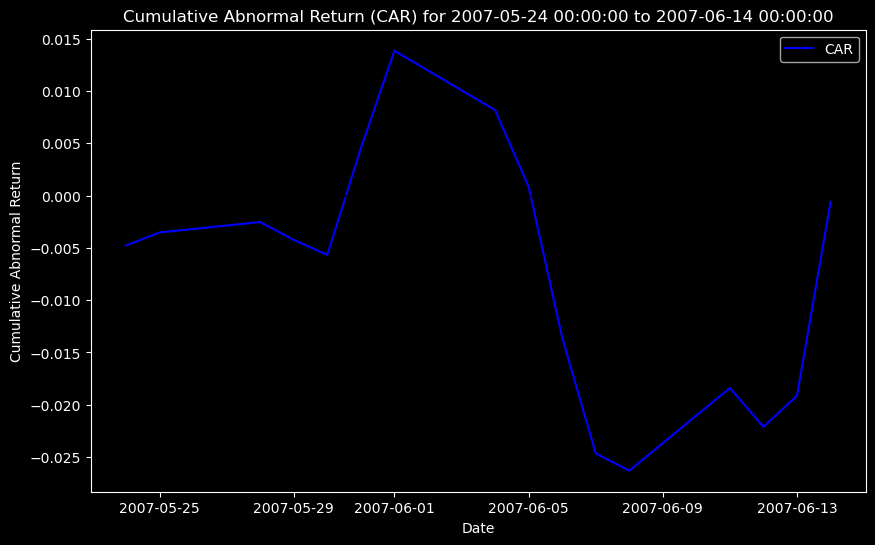


2007 Event: 2007-05-24 00:00:00 to 2007-06-14 00:00:00
Mean CAR: -0.0074, Std Dev: 0.0120
T-Statistic: -2.4520, CAR P-Value: 0.0269


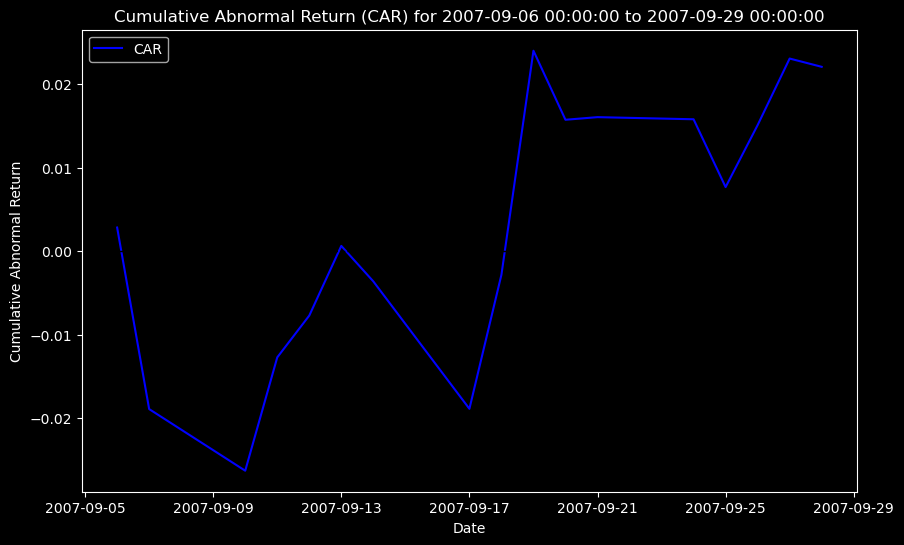


2007 Event: 2007-09-06 00:00:00 to 2007-09-29 00:00:00
Mean CAR: 0.0030, Std Dev: 0.0161
T-Statistic: 0.7804, CAR P-Value: 0.4465

2007 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9116, Variance P-Value: 0.3641

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1229.681, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1224.000, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1222.882, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1223.186, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1223.283, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1223.727, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1226.011, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1228.828, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]         

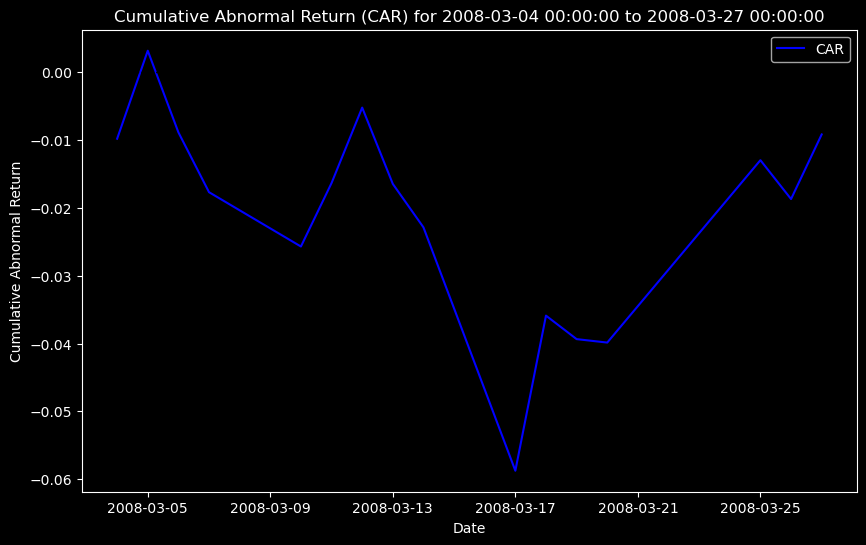


2008 Event: 2008-03-04 00:00:00 to 2008-03-27 00:00:00
Mean CAR: -0.0209, Std Dev: 0.0158
T-Statistic: -5.2982, CAR P-Value: 0.0001


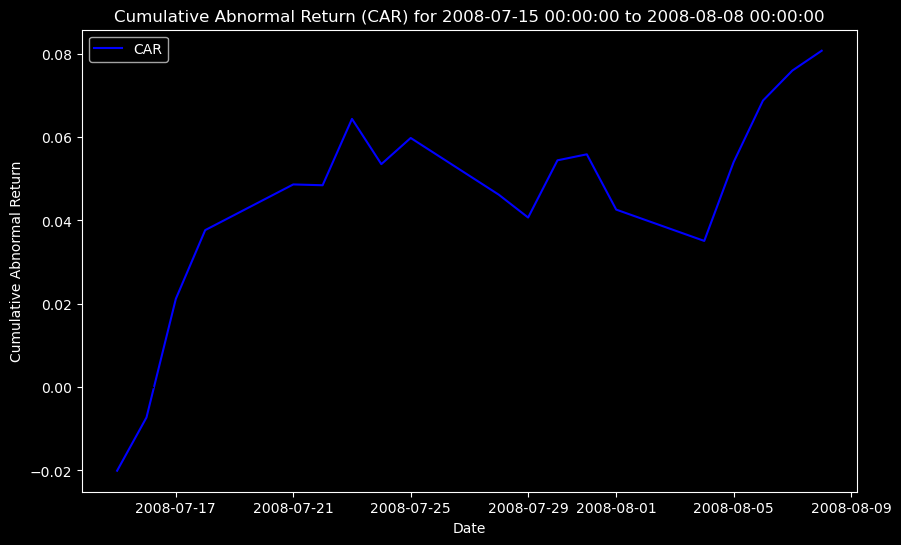


2008 Event: 2008-07-15 00:00:00 to 2008-08-08 00:00:00
Mean CAR: 0.0453, Std Dev: 0.0253
T-Statistic: 7.8159, CAR P-Value: 0.0000


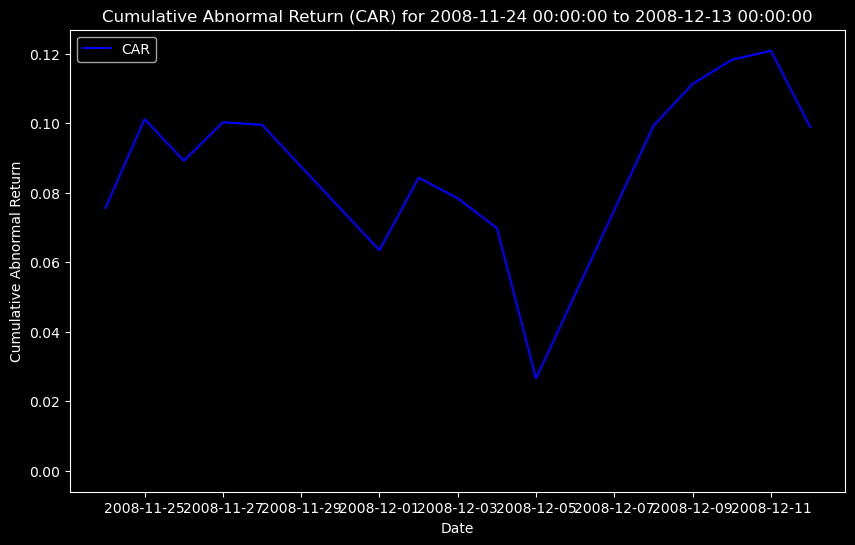


2008 Event: 2008-11-24 00:00:00 to 2008-12-13 00:00:00
Mean CAR: 0.0891, Std Dev: 0.0242
T-Statistic: 14.2681, CAR P-Value: 0.0000

2008 Variance Comparison
Event Variance: 0.0005, Non-Event Variance: 0.0005
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9280, Variance P-Value: 0.3883

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1456.252, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1457.896, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1455.918, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1455.908, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1451.428, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1457.265, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.206 seconds
Best ARIMA order for 2009: (0, 0, 0)


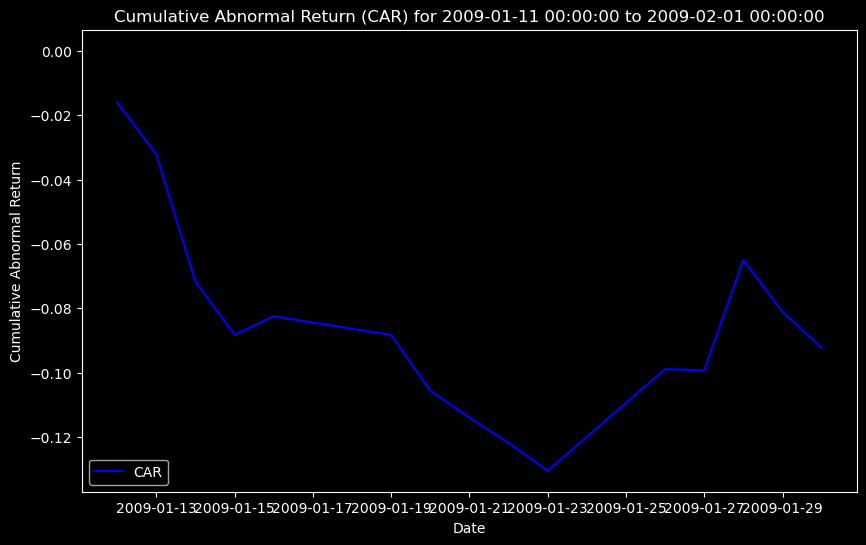


2009 Event: 2009-01-11 00:00:00 to 2009-02-01 00:00:00
Mean CAR: -0.0858, Std Dev: 0.0308
T-Statistic: -10.7873, CAR P-Value: 0.0000


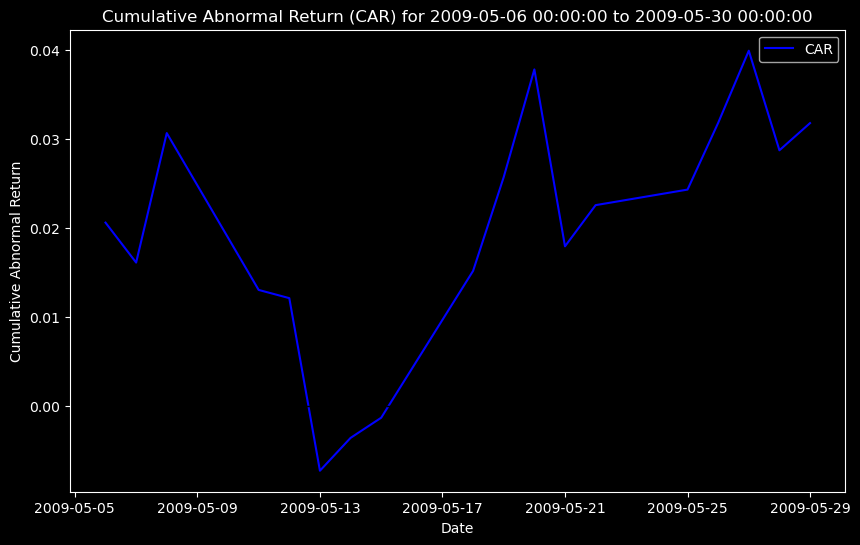


2009 Event: 2009-05-06 00:00:00 to 2009-05-30 00:00:00
Mean CAR: 0.0198, Std Dev: 0.0136
T-Statistic: 6.1647, CAR P-Value: 0.0000


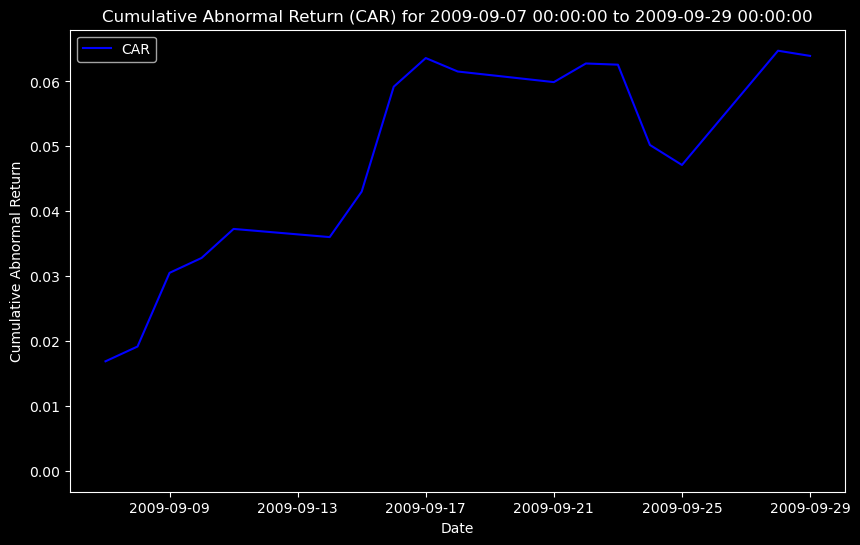


2009 Event: 2009-09-07 00:00:00 to 2009-09-29 00:00:00
Mean CAR: 0.0477, Std Dev: 0.0164
T-Statistic: 12.0208, CAR P-Value: 0.0000

2009 Variance Comparison
Event Variance: 0.0002, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9986, Variance P-Value: 0.5159

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1522.151, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1520.169, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1520.170, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1518.187, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1520.280, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.306 seconds
Best ARIMA order for 2010: (0, 0, 0)


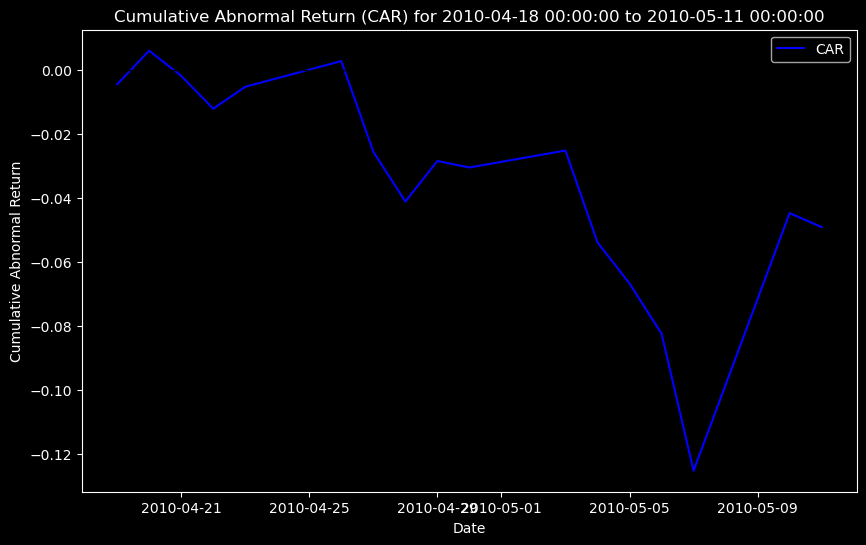


2010 Event: 2010-04-18 00:00:00 to 2010-05-11 00:00:00
Mean CAR: -0.0346, Std Dev: 0.0344
T-Statistic: -4.1541, CAR P-Value: 0.0007


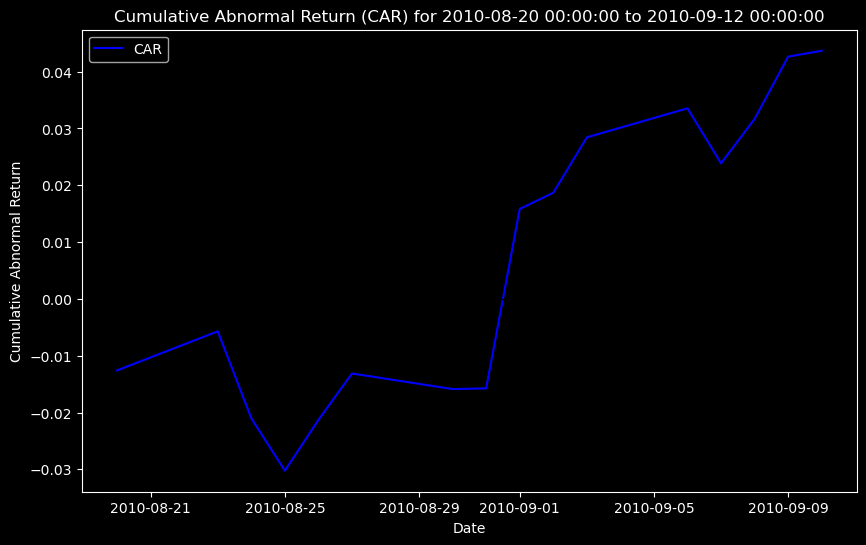


2010 Event: 2010-08-20 00:00:00 to 2010-09-12 00:00:00
Mean CAR: 0.0064, Std Dev: 0.0256
T-Statistic: 1.0023, CAR P-Value: 0.3321


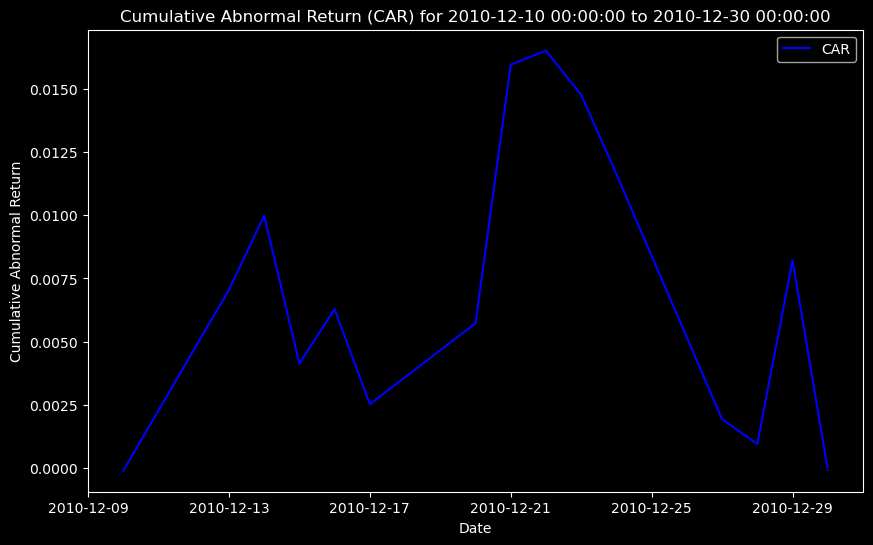


2010 Event: 2010-12-10 00:00:00 to 2010-12-30 00:00:00
Mean CAR: 0.0070, Std Dev: 0.0057
T-Statistic: 4.7667, CAR P-Value: 0.0003

2010 Variance Comparison
Event Variance: 0.0003, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): 0.0002
F-Statistic for Variance Comparison: 2.3025, Variance P-Value: 1.0000

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1398.158, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1399.724, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1401.584, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1401.724, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1399.560, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1399.735, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1400.793, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1399.882, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.380 seconds
Best ARIMA order 

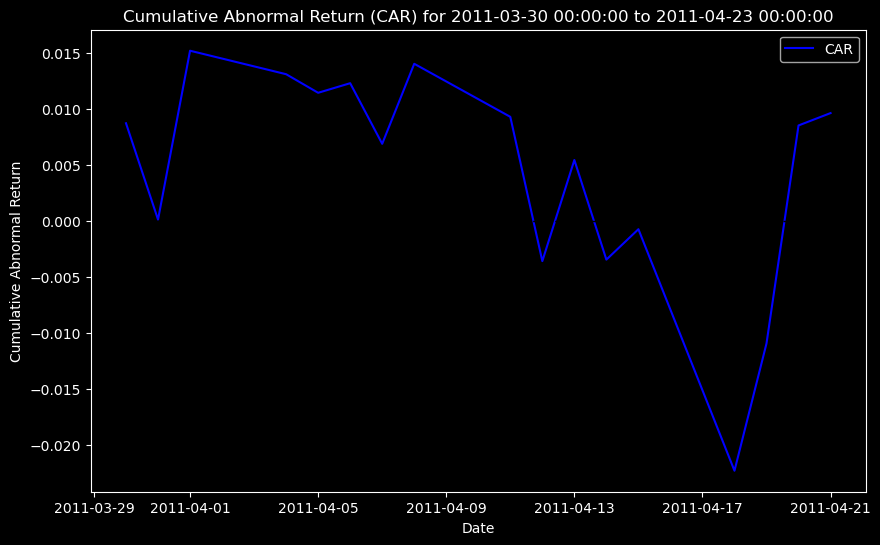


2011 Event: 2011-03-30 00:00:00 to 2011-04-23 00:00:00
Mean CAR: 0.0043, Std Dev: 0.0100
T-Statistic: 1.7757, CAR P-Value: 0.0948


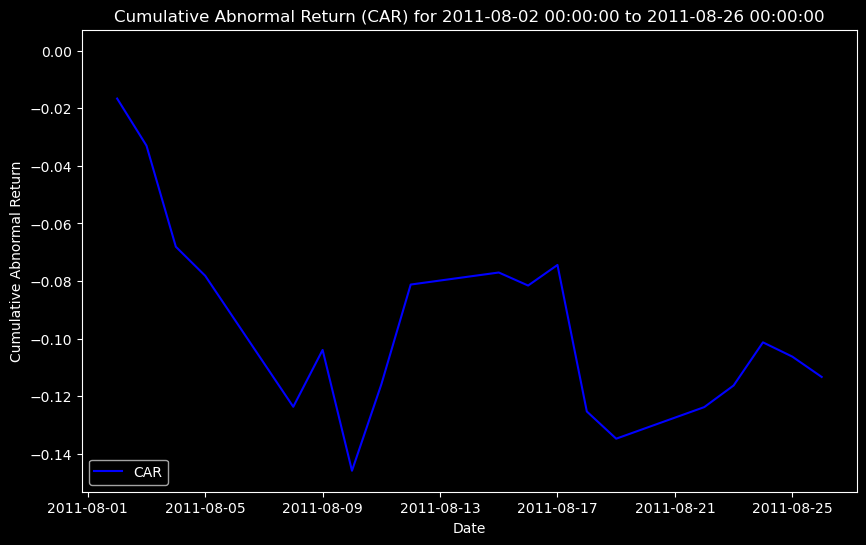


2011 Event: 2011-08-02 00:00:00 to 2011-08-26 00:00:00
Mean CAR: -0.0958, Std Dev: 0.0336
T-Statistic: -12.4315, CAR P-Value: 0.0000


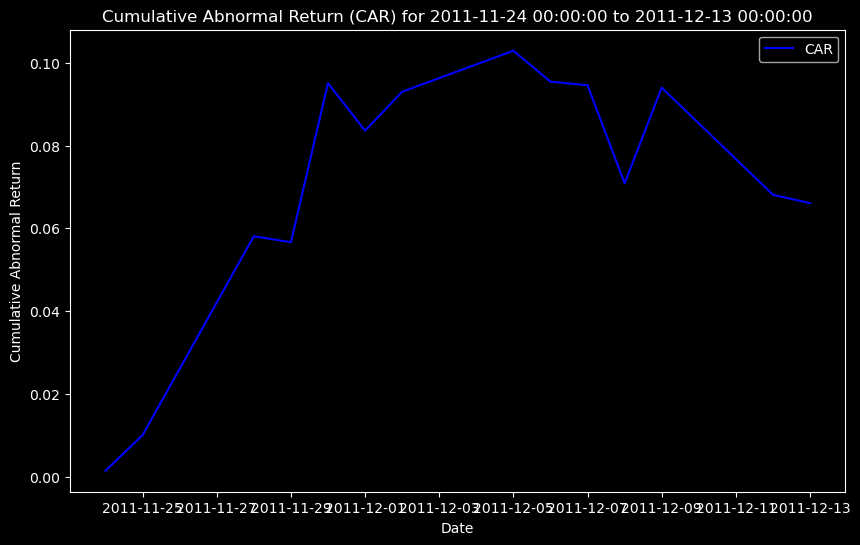


2011 Event: 2011-11-24 00:00:00 to 2011-12-13 00:00:00
Mean CAR: 0.0707, Std Dev: 0.0315
T-Statistic: 8.4021, CAR P-Value: 0.0000

2011 Variance Comparison
Event Variance: 0.0004, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): 0.0001
F-Statistic for Variance Comparison: 1.6061, Variance P-Value: 0.9883

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1553.746, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1560.434, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1558.617, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1558.624, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1556.434, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1559.662, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.167 seconds
Best ARIMA order for 2012: (0, 0, 0)


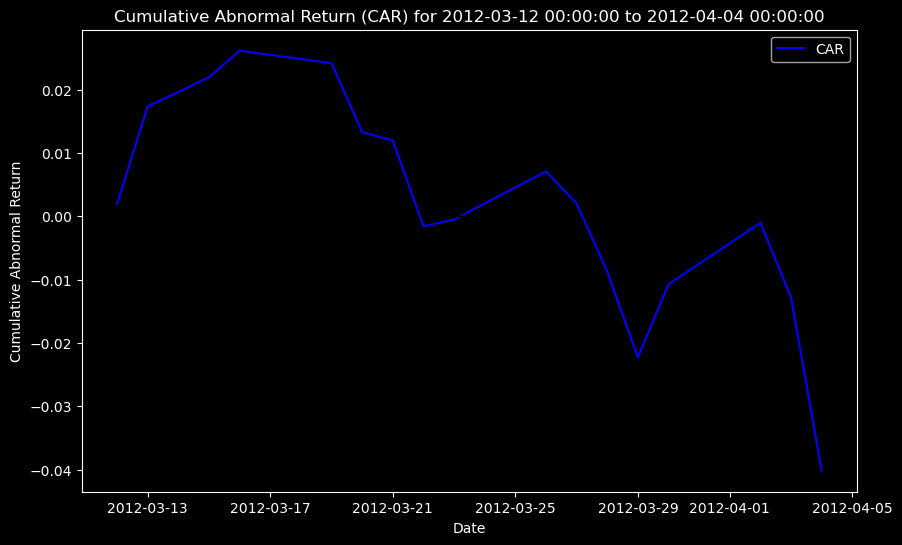


2012 Event: 2012-03-12 00:00:00 to 2012-04-04 00:00:00
Mean CAR: 0.0026, Std Dev: 0.0174
T-Statistic: 0.6441, CAR P-Value: 0.5281


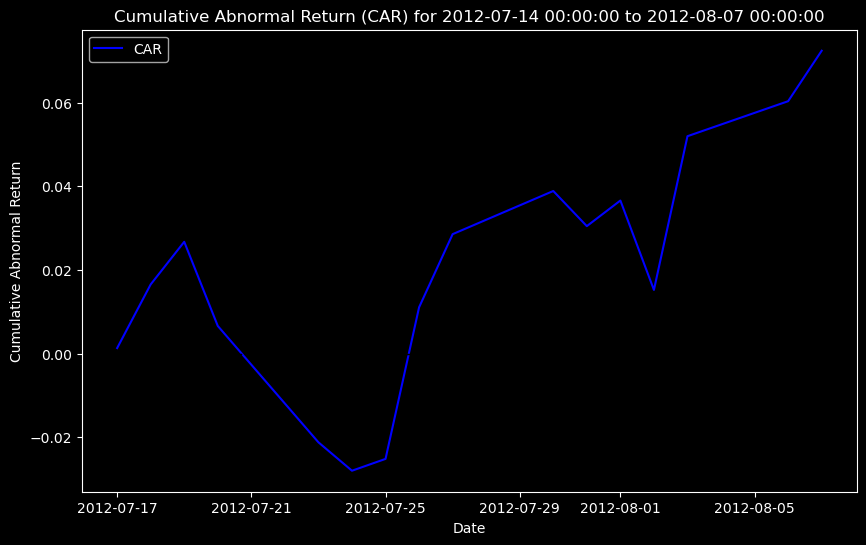


2012 Event: 2012-07-14 00:00:00 to 2012-08-07 00:00:00
Mean CAR: 0.0202, Std Dev: 0.0294
T-Statistic: 2.7445, CAR P-Value: 0.0151


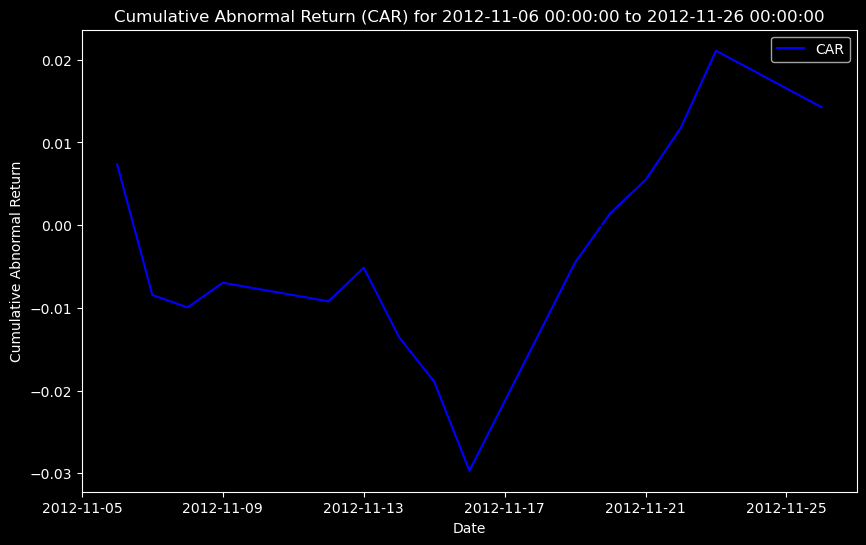


2012 Event: 2012-11-06 00:00:00 to 2012-11-26 00:00:00
Mean CAR: -0.0030, Std Dev: 0.0134
T-Statistic: -0.8667, CAR P-Value: 0.4007

2012 Variance Comparison
Event Variance: 0.0002, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): 0.0000
F-Statistic for Variance Comparison: 1.3613, Variance P-Value: 0.9272

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1682.027, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1681.630, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1680.421, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1680.407, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1676.372, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1676.434, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1678.064, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1677.505, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1678.422, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]  

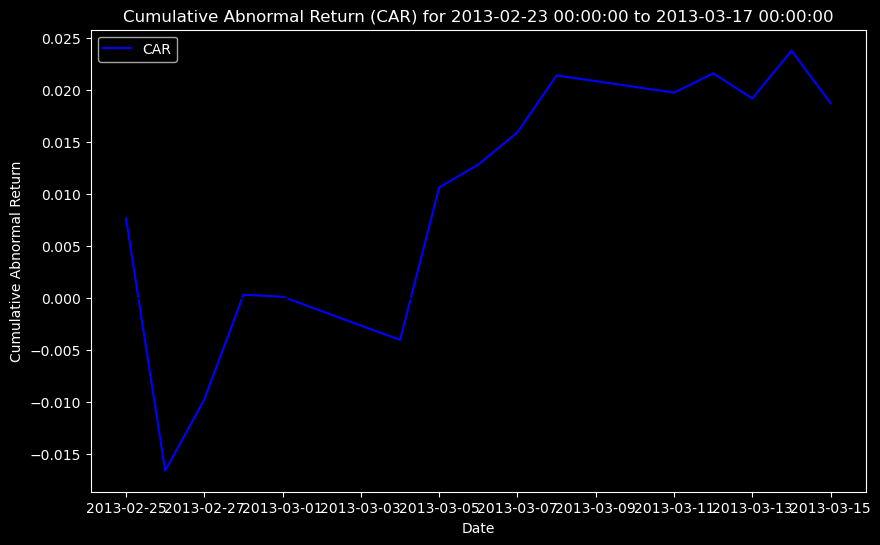


2013 Event: 2013-02-23 00:00:00 to 2013-03-17 00:00:00
Mean CAR: 0.0094, Std Dev: 0.0127
T-Statistic: 2.8850, CAR P-Value: 0.0120


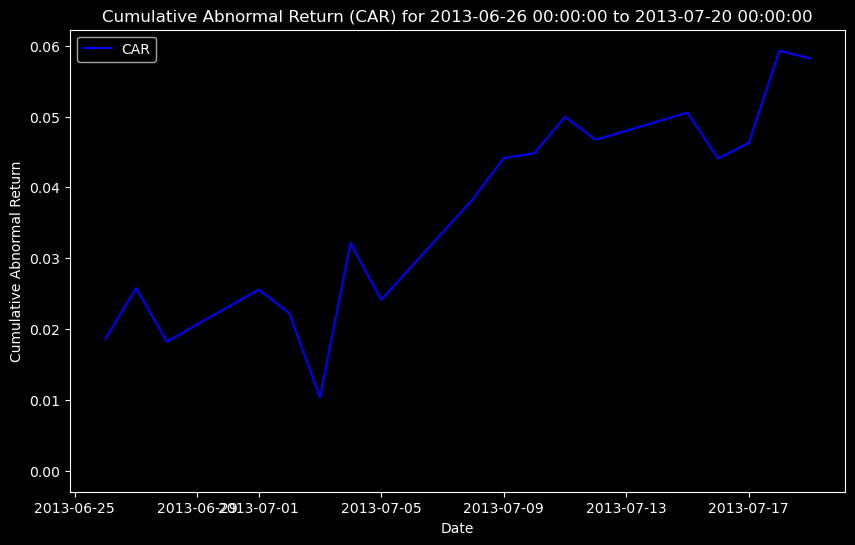


2013 Event: 2013-06-26 00:00:00 to 2013-07-20 00:00:00
Mean CAR: 0.0366, Std Dev: 0.0148
T-Statistic: 10.5321, CAR P-Value: 0.0000


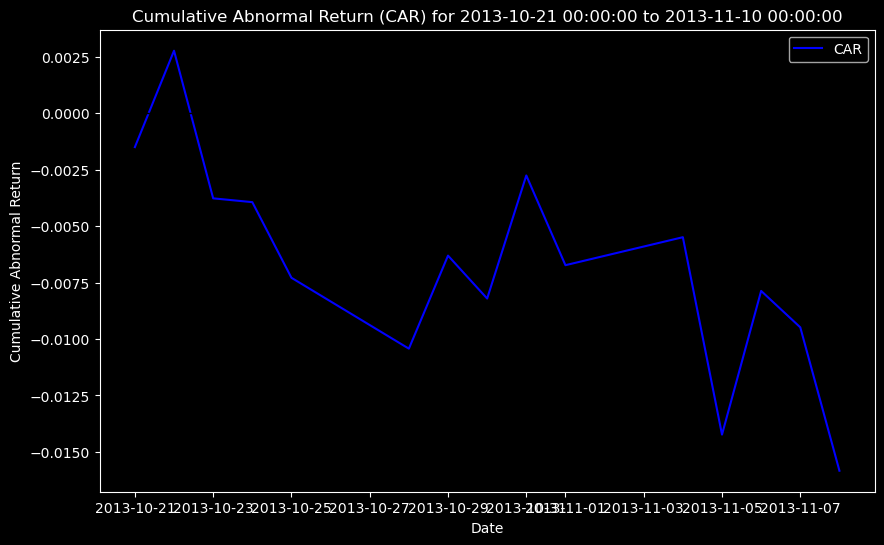


2013 Event: 2013-10-21 00:00:00 to 2013-11-10 00:00:00
Mean CAR: -0.0067, Std Dev: 0.0048
T-Statistic: -5.4919, CAR P-Value: 0.0001

2013 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.8810, Variance P-Value: 0.3094

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1683.525, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1686.405, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1684.698, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1684.688, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1682.182, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1684.674, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.268 seconds
Best ARIMA order for 2014: (0, 0, 0)


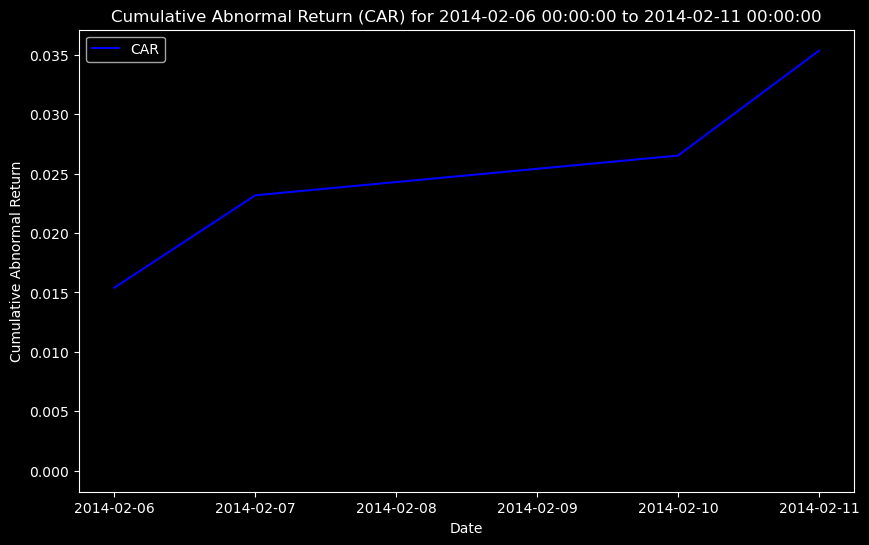


2014 Event: 2014-02-06 00:00:00 to 2014-02-11 00:00:00
Mean CAR: 0.0251, Std Dev: 0.0083
T-Statistic: 6.0804, CAR P-Value: 0.0089


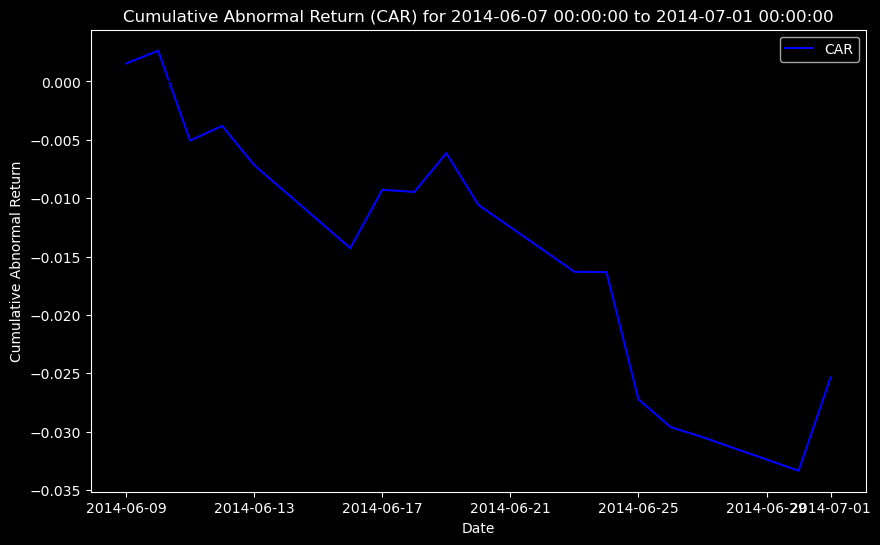


2014 Event: 2014-06-07 00:00:00 to 2014-07-01 00:00:00
Mean CAR: -0.0141, Std Dev: 0.0114
T-Statistic: -5.1252, CAR P-Value: 0.0001


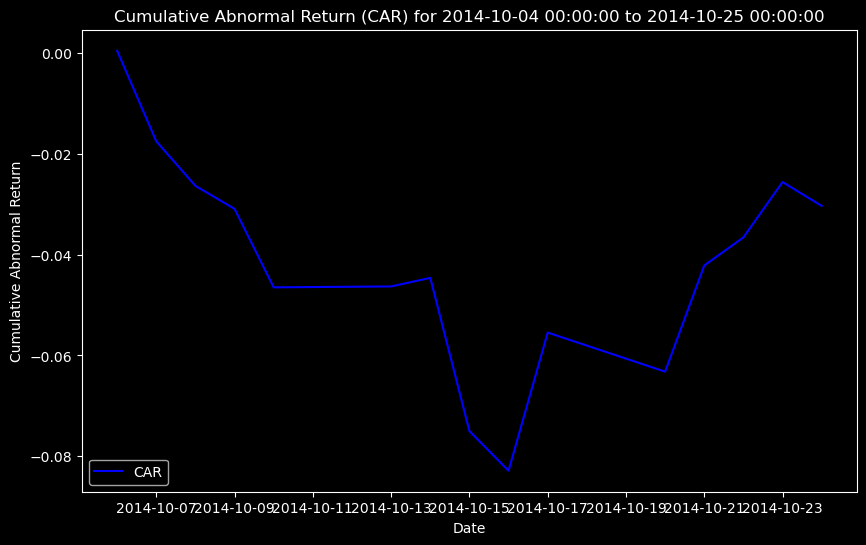


2014 Event: 2014-10-04 00:00:00 to 2014-10-25 00:00:00
Mean CAR: -0.0415, Std Dev: 0.0218
T-Statistic: -7.3845, CAR P-Value: 0.0000

2014 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): 0.0000
F-Statistic for Variance Comparison: 1.4146, Variance P-Value: 0.9280

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1504.158, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1511.346, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1509.380, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1509.363, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1507.348, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1509.831, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.232 seconds
Best ARIMA order for 2015: (0, 0, 0)


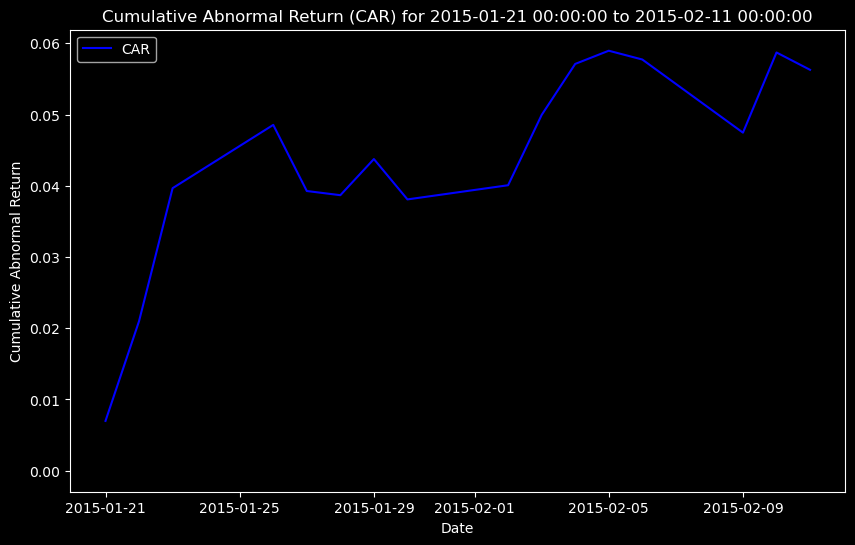


2015 Event: 2015-01-21 00:00:00 to 2015-02-11 00:00:00
Mean CAR: 0.0439, Std Dev: 0.0142
T-Statistic: 12.3374, CAR P-Value: 0.0000


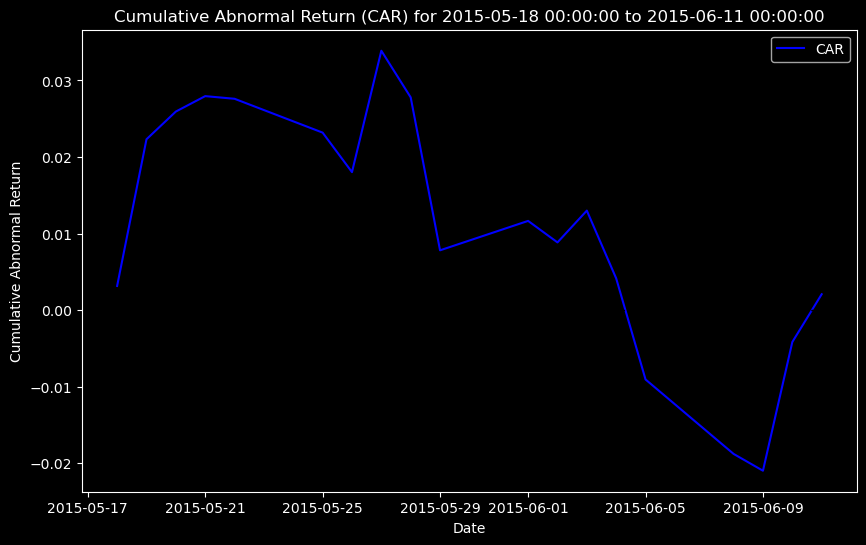


2015 Event: 2015-05-18 00:00:00 to 2015-06-11 00:00:00
Mean CAR: 0.0108, Std Dev: 0.0161
T-Statistic: 2.9115, CAR P-Value: 0.0093


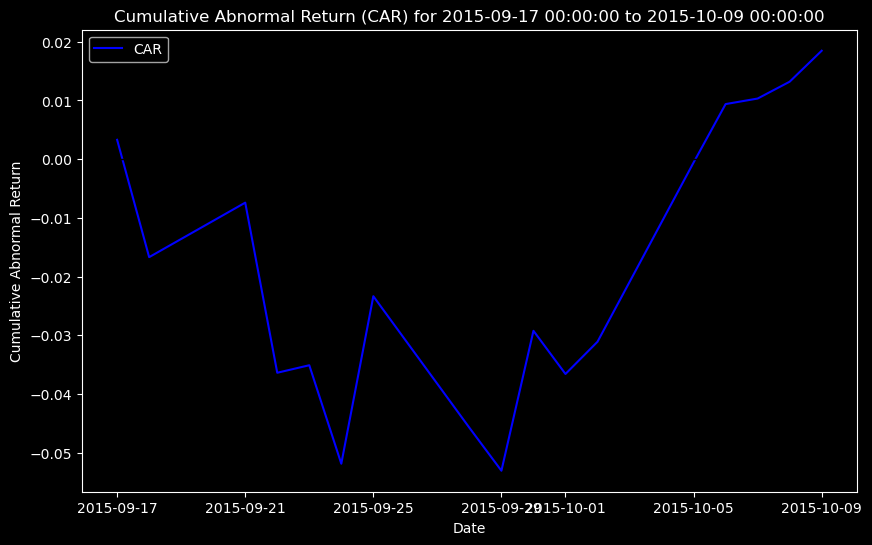


2015 Event: 2015-09-17 00:00:00 to 2015-10-09 00:00:00
Mean CAR: -0.0184, Std Dev: 0.0240
T-Statistic: -3.1660, CAR P-Value: 0.0060

2015 Variance Comparison
Event Variance: 0.0002, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9339, Variance P-Value: 0.3968

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1561.878, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1560.083, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1559.596, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1559.855, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1557.868, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1556.803, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1558.944, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1558.474, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1561.191, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] 

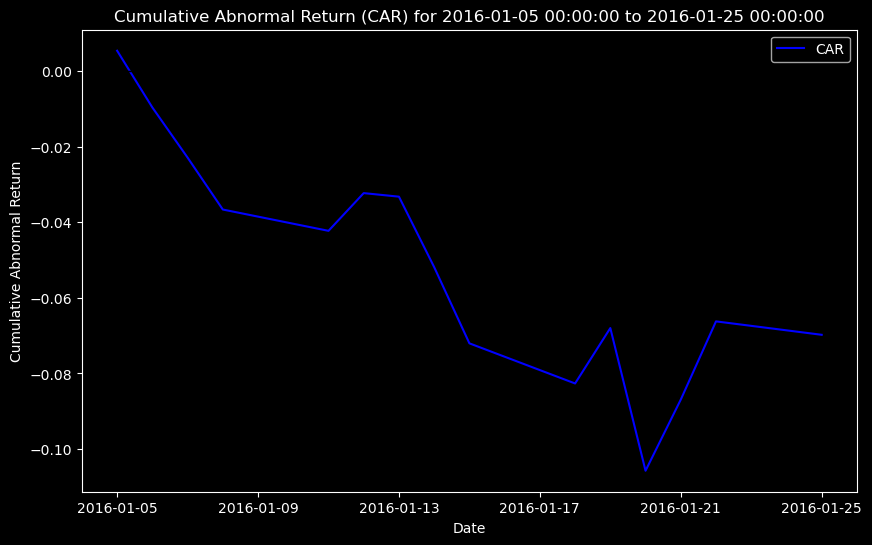


2016 Event: 2016-01-05 00:00:00 to 2016-01-25 00:00:00
Mean CAR: -0.0516, Std Dev: 0.0308
T-Statistic: -6.5019, CAR P-Value: 0.0000


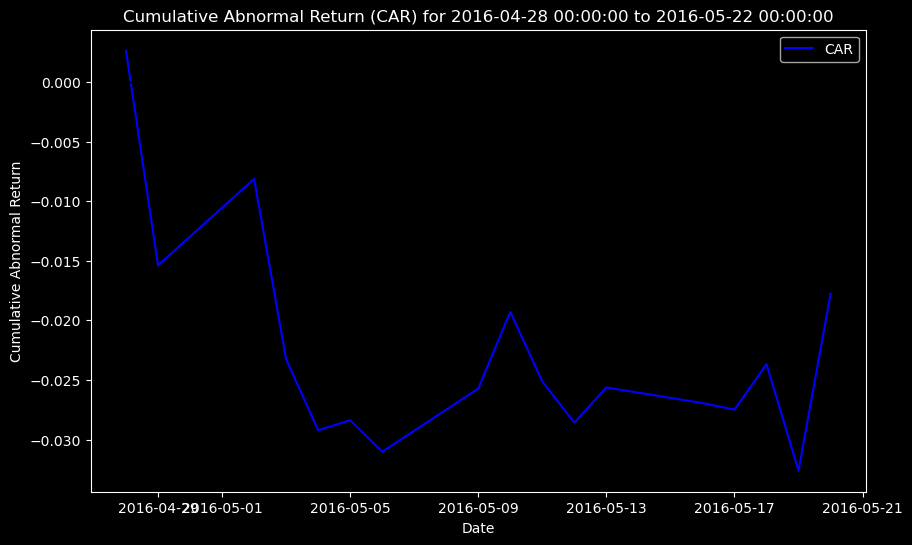


2016 Event: 2016-04-28 00:00:00 to 2016-05-22 00:00:00
Mean CAR: -0.0227, Std Dev: 0.0090
T-Statistic: -10.4308, CAR P-Value: 0.0000


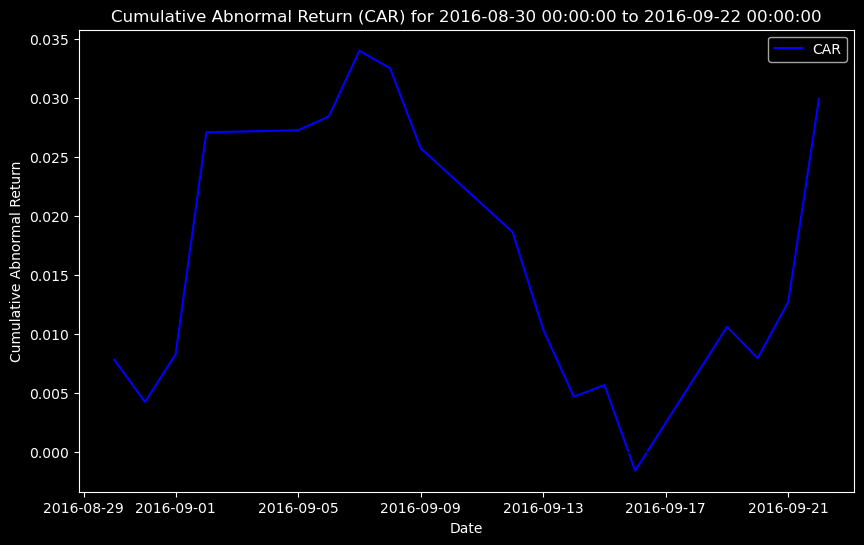


2016 Event: 2016-08-30 00:00:00 to 2016-09-22 00:00:00
Mean CAR: 0.0163, Std Dev: 0.0115
T-Statistic: 6.0412, CAR P-Value: 0.0000

2016 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9777, Variance P-Value: 0.4787

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1881.342, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1889.342, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1887.894, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1887.897, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1885.758, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1890.360, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1888.676, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1888.686, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1886.677, Time=0.03 sec

Best model:  ARIMA(0,0,0)

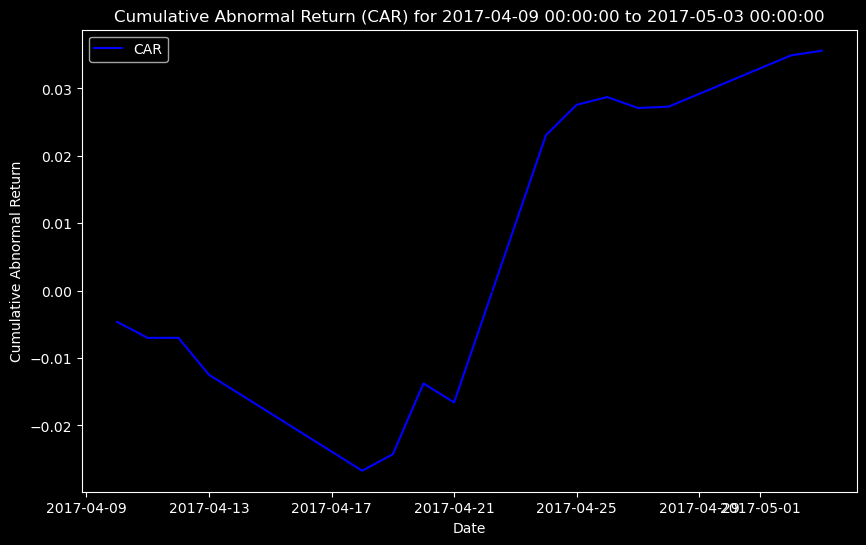


2017 Event: 2017-04-09 00:00:00 to 2017-05-03 00:00:00
Mean CAR: 0.0061, Std Dev: 0.0232
T-Statistic: 1.0195, CAR P-Value: 0.3252


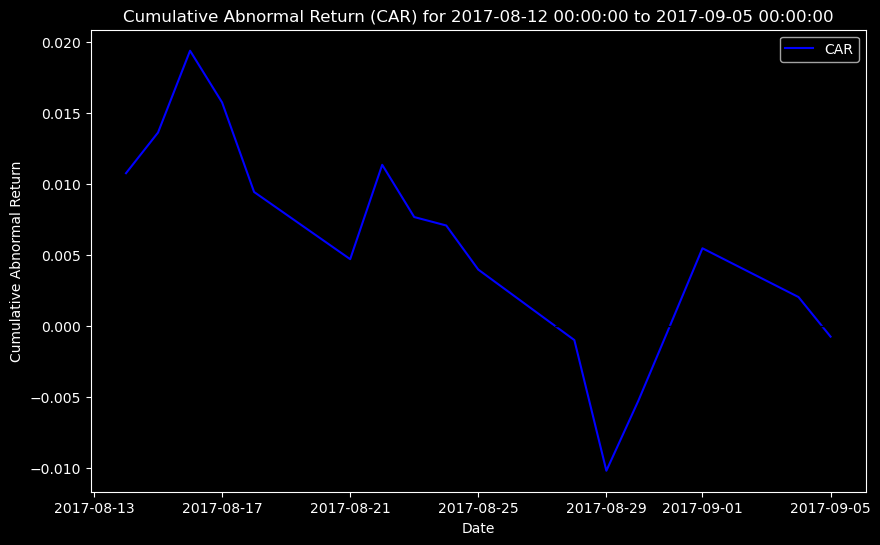


2017 Event: 2017-08-12 00:00:00 to 2017-09-05 00:00:00
Mean CAR: 0.0055, Std Dev: 0.0077
T-Statistic: 2.9775, CAR P-Value: 0.0089


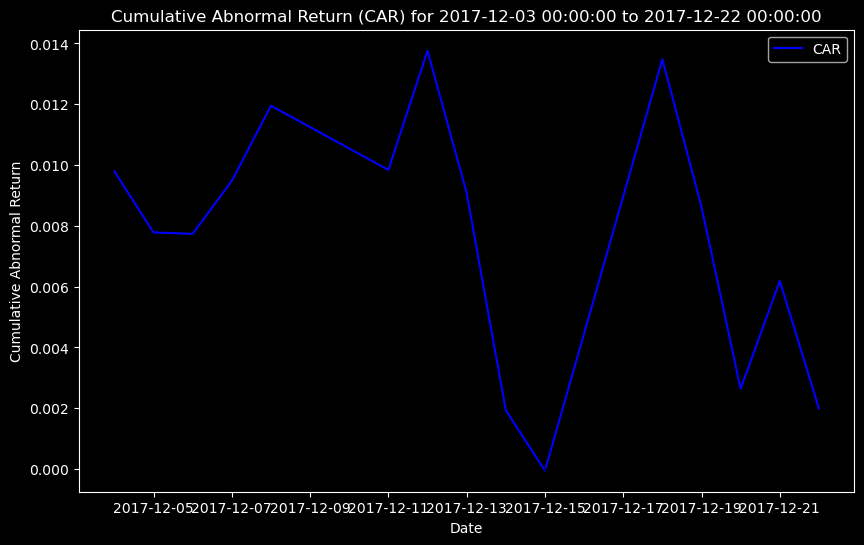


2017 Event: 2017-12-03 00:00:00 to 2017-12-22 00:00:00
Mean CAR: 0.0076, Std Dev: 0.0043
T-Statistic: 6.8849, CAR P-Value: 0.0000

2017 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0000
Variance Difference (Event - Non-Event): 0.0000
F-Statistic for Variance Comparison: 2.1939, Variance P-Value: 0.9999

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1715.829, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1720.394, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1720.176, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1720.087, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1716.173, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1718.529, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.229 seconds
Best ARIMA order for 2018: (0, 0, 0)


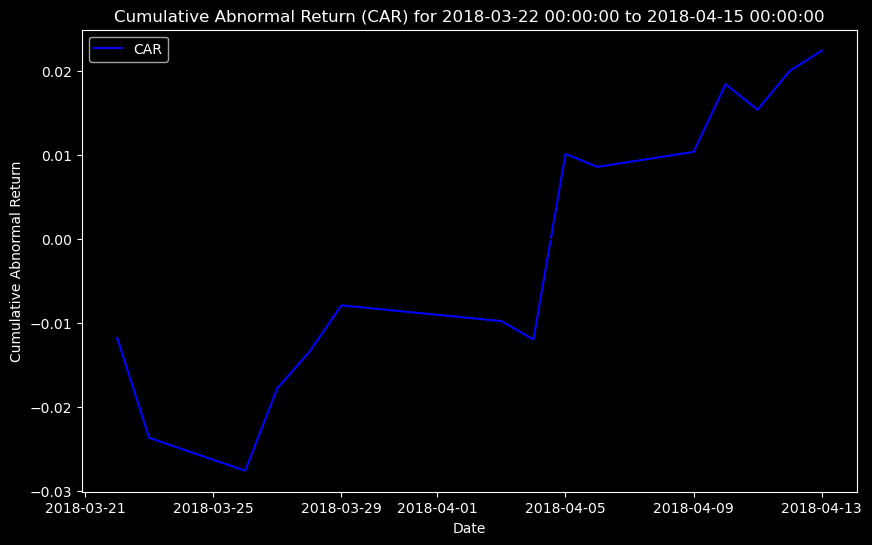


2018 Event: 2018-03-22 00:00:00 to 2018-04-15 00:00:00
Mean CAR: -0.0013, Std Dev: 0.0169
T-Statistic: -0.2864, CAR P-Value: 0.7787


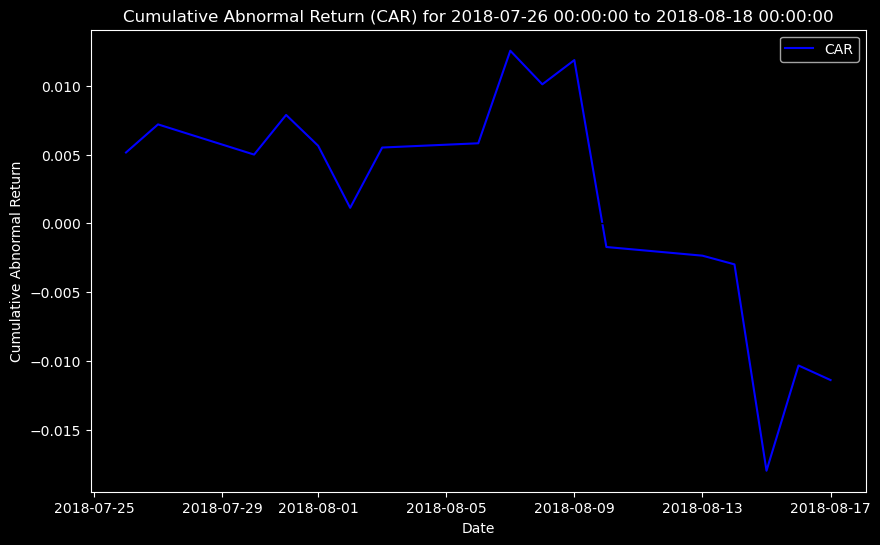


2018 Event: 2018-07-26 00:00:00 to 2018-08-18 00:00:00
Mean CAR: 0.0018, Std Dev: 0.0086
T-Statistic: 0.8780, CAR P-Value: 0.3930


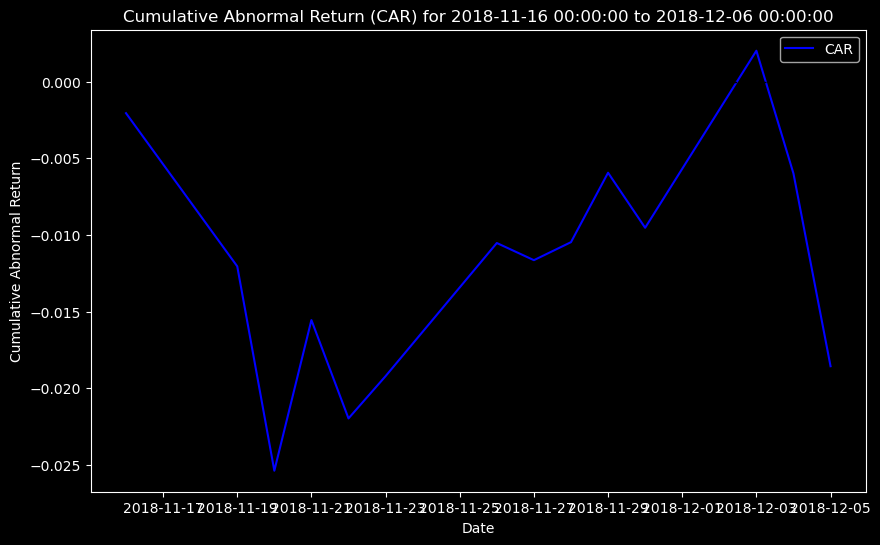


2018 Event: 2018-11-16 00:00:00 to 2018-12-06 00:00:00
Mean CAR: -0.0119, Std Dev: 0.0077
T-Statistic: -5.8182, CAR P-Value: 0.0001

2018 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9088, Variance P-Value: 0.3606

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1678.272, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1686.140, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1684.302, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1684.300, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1682.311, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1688.058, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1686.079, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1686.065, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1684.081, Time=0.06 sec

Best model:  ARIMA(0,0,

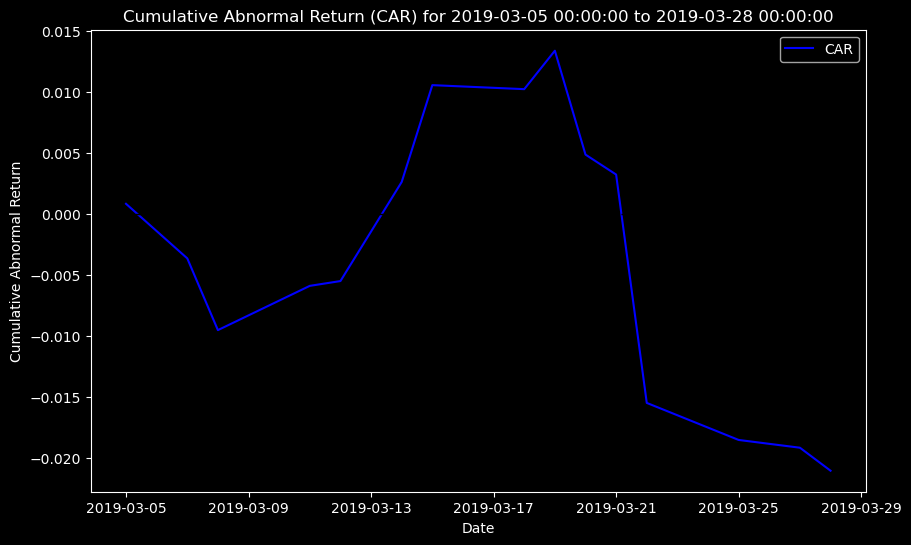


2019 Event: 2019-03-05 00:00:00 to 2019-03-28 00:00:00
Mean CAR: -0.0035, Std Dev: 0.0114
T-Statistic: -1.2041, CAR P-Value: 0.2485


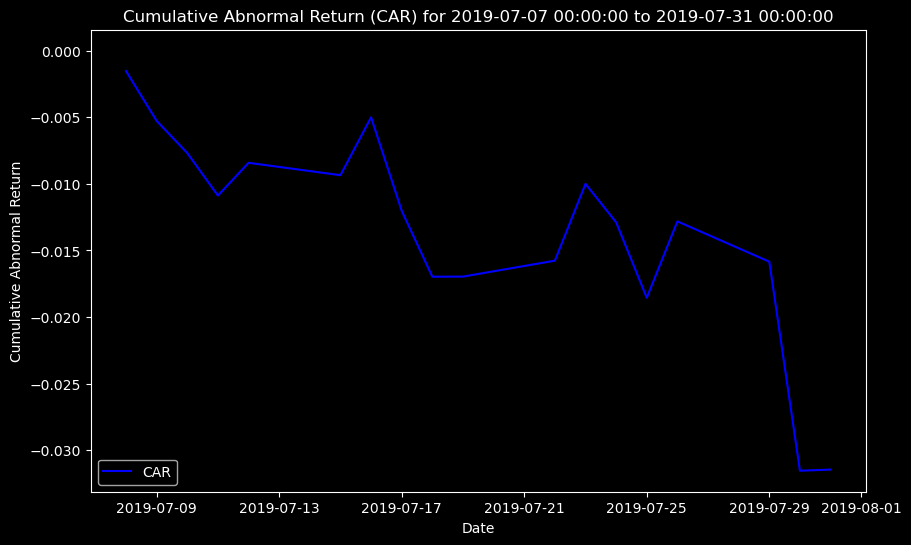


2019 Event: 2019-07-07 00:00:00 to 2019-07-31 00:00:00
Mean CAR: -0.0135, Std Dev: 0.0080
T-Statistic: -7.1496, CAR P-Value: 0.0000


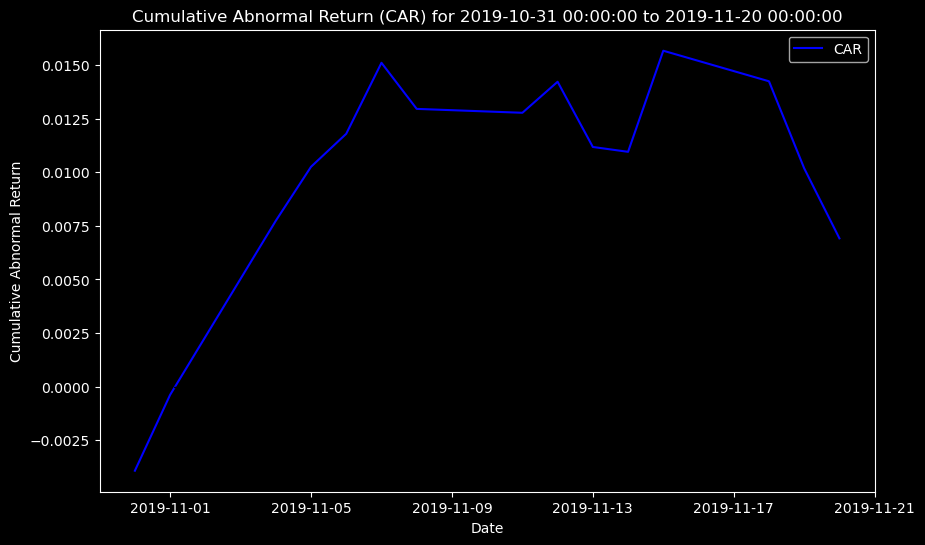


2019 Event: 2019-10-31 00:00:00 to 2019-11-20 00:00:00
Mean CAR: 0.0100, Std Dev: 0.0056
T-Statistic: 6.9572, CAR P-Value: 0.0000

2019 Variance Comparison
Event Variance: 0.0000, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.5193, Variance P-Value: 0.0045

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1308.918, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1307.900, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1305.941, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1305.905, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1310.700, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1311.558, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-1310.218, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1306.954, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1317.660, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]   

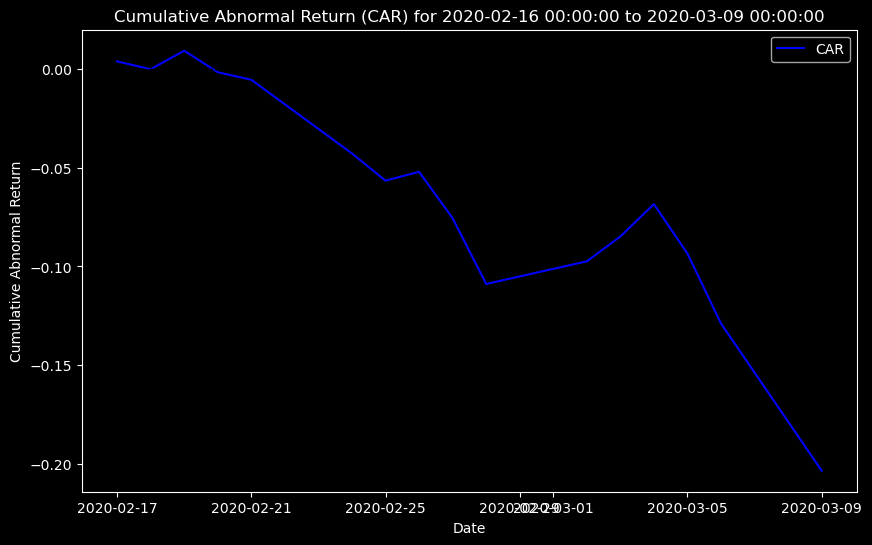


2020 Event: 2020-02-16 00:00:00 to 2020-03-09 00:00:00
Mean CAR: -0.0630, Std Dev: 0.0578
T-Statistic: -4.3571, CAR P-Value: 0.0006


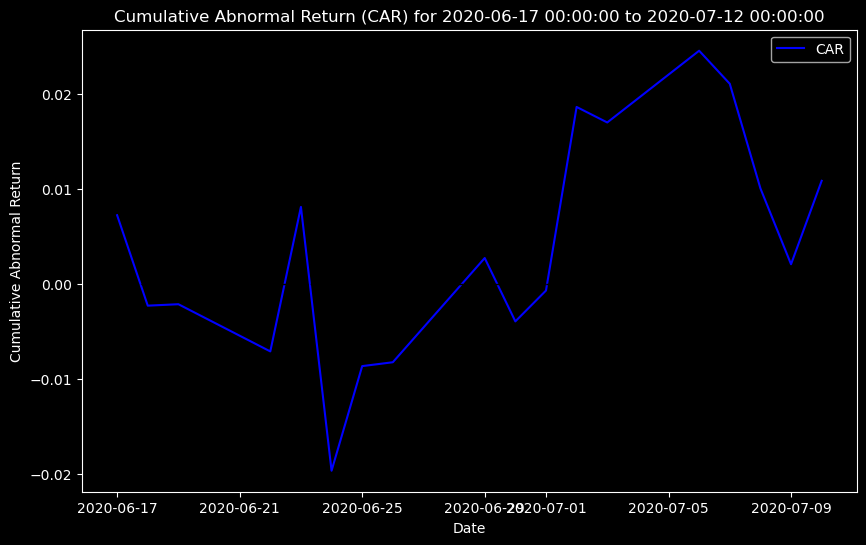


2020 Event: 2020-06-17 00:00:00 to 2020-07-12 00:00:00
Mean CAR: 0.0038, Std Dev: 0.0118
T-Statistic: 1.3794, CAR P-Value: 0.1856


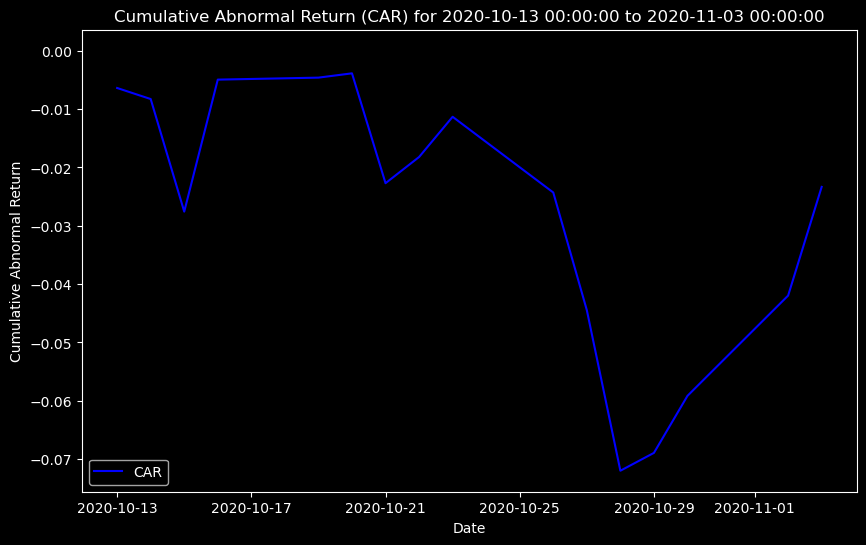


2020 Event: 2020-10-13 00:00:00 to 2020-11-03 00:00:00
Mean CAR: -0.0276, Std Dev: 0.0231
T-Statistic: -4.7863, CAR P-Value: 0.0002

2020 Variance Comparison
Event Variance: 0.0003, Non-Event Variance: 0.0004
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.8986, Variance P-Value: 0.3362

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1741.074, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1743.101, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1743.933, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1743.754, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1742.231, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1743.529, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1740.173, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1747.550, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1745.576, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] 

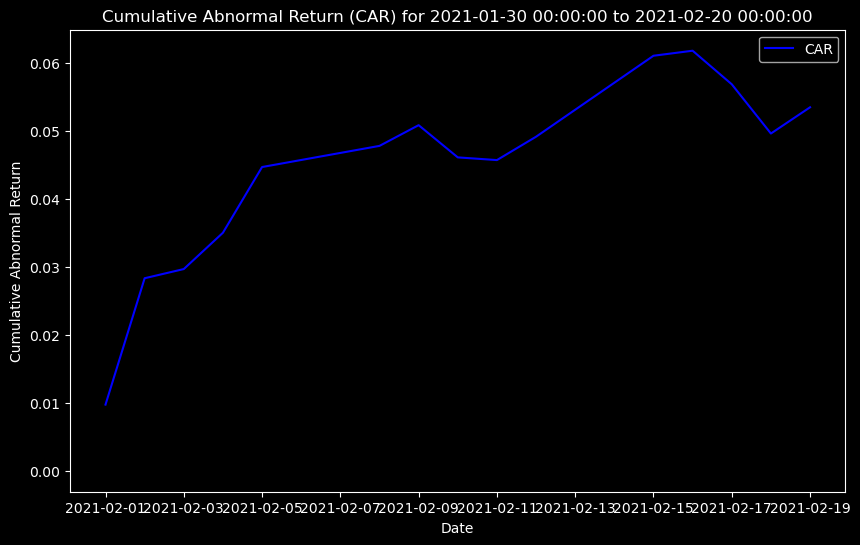


2021 Event: 2021-01-30 00:00:00 to 2021-02-20 00:00:00
Mean CAR: 0.0447, Std Dev: 0.0139
T-Statistic: 12.4768, CAR P-Value: 0.0000


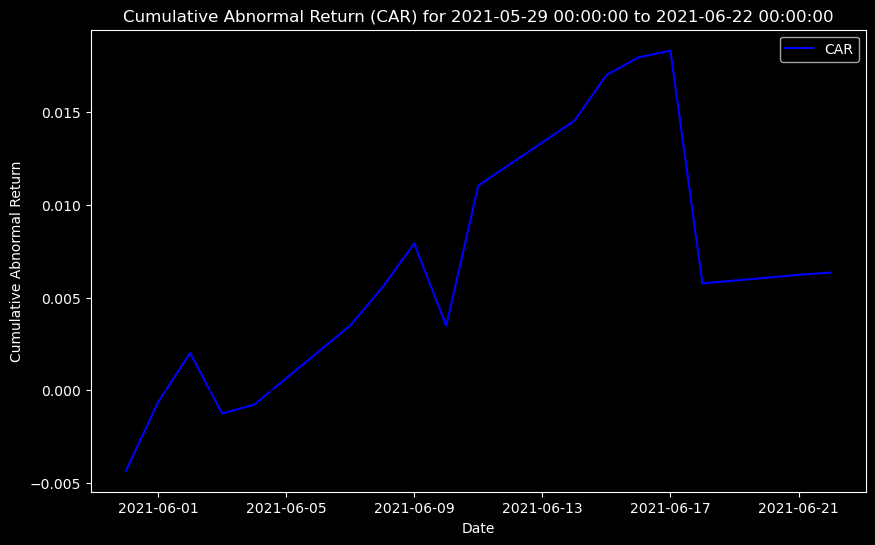


2021 Event: 2021-05-29 00:00:00 to 2021-06-22 00:00:00
Mean CAR: 0.0066, Std Dev: 0.0070
T-Statistic: 3.8838, CAR P-Value: 0.0013


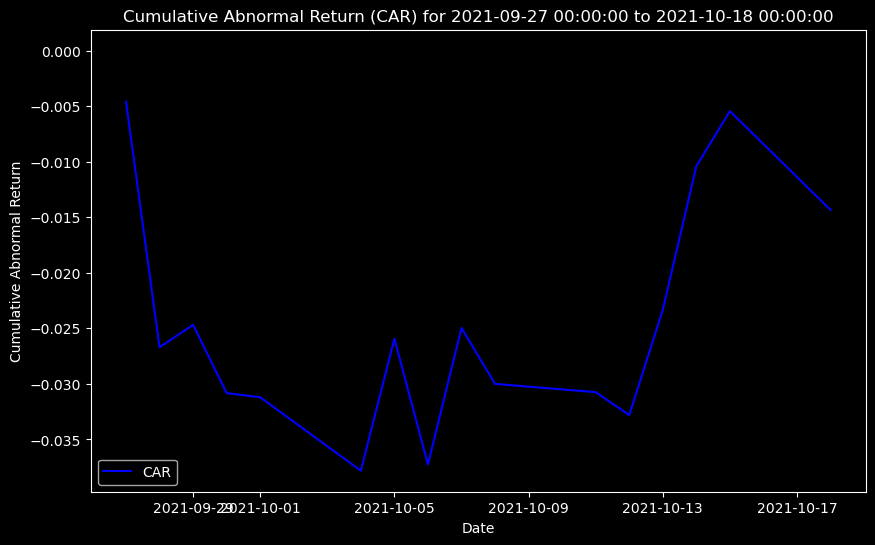


2021 Event: 2021-09-27 00:00:00 to 2021-10-18 00:00:00
Mean CAR: -0.0244, Std Dev: 0.0104
T-Statistic: -9.3682, CAR P-Value: 0.0000

2021 Variance Comparison
Event Variance: 0.0001, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9244, Variance P-Value: 0.3850

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1476.375, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1474.402, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1474.403, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1472.417, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1474.446, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.312 seconds
Best ARIMA order for 2022: (0, 0, 0)


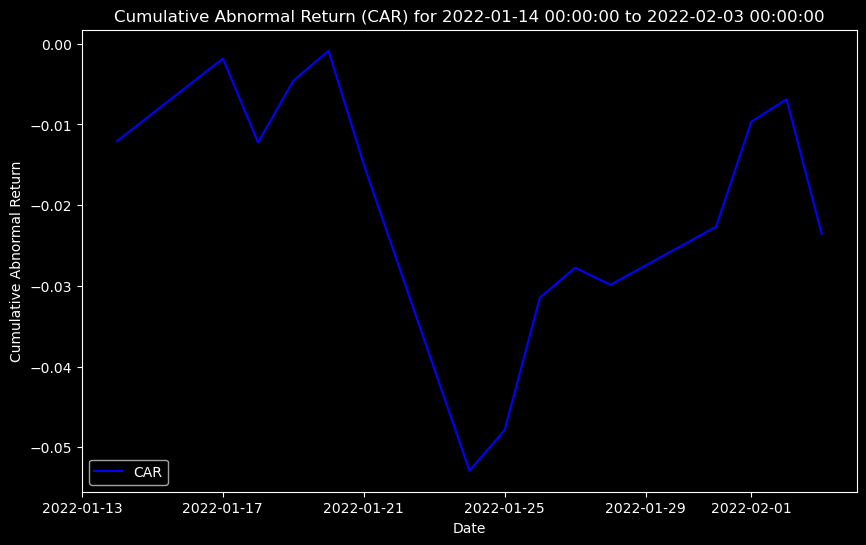


2022 Event: 2022-01-14 00:00:00 to 2022-02-03 00:00:00
Mean CAR: -0.0199, Std Dev: 0.0159
T-Statistic: -4.8632, CAR P-Value: 0.0003


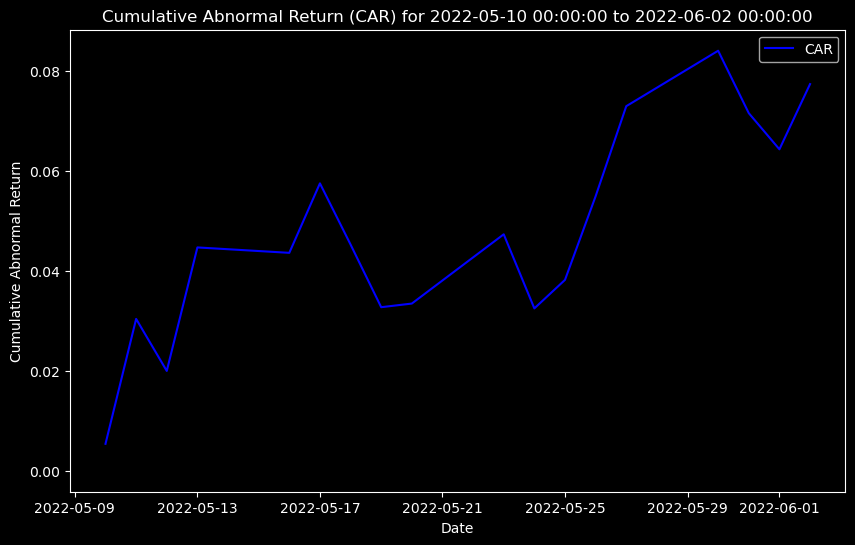


2022 Event: 2022-05-10 00:00:00 to 2022-06-02 00:00:00
Mean CAR: 0.0475, Std Dev: 0.0210
T-Statistic: 9.6243, CAR P-Value: 0.0000


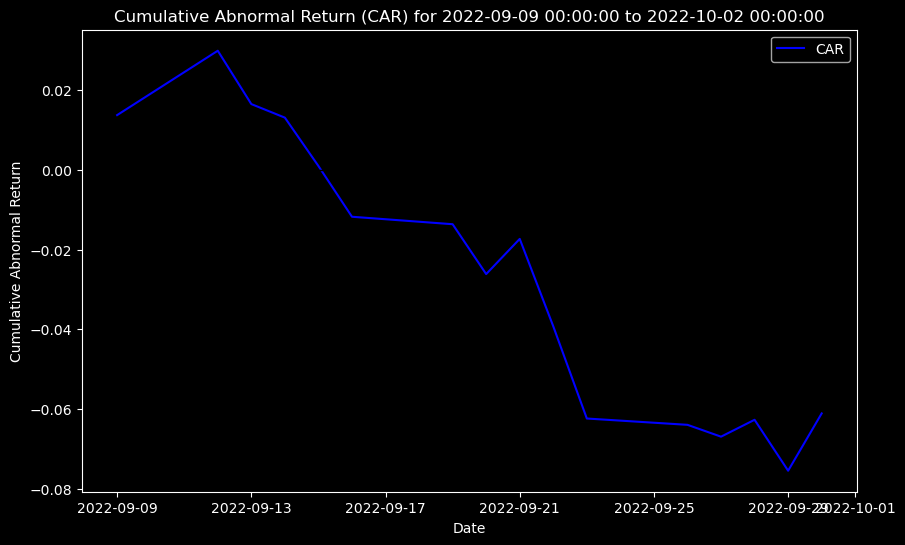


2022 Event: 2022-09-09 00:00:00 to 2022-10-02 00:00:00
Mean CAR: -0.0267, Std Dev: 0.0354
T-Statistic: -3.0103, CAR P-Value: 0.0088

2022 Variance Comparison
Event Variance: 0.0002, Non-Event Variance: 0.0002
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.9657, Variance P-Value: 0.4578

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1674.792, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1680.909, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1679.846, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1679.745, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1677.800, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1680.079, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Best ARIMA order for 2023: (0, 0, 0)


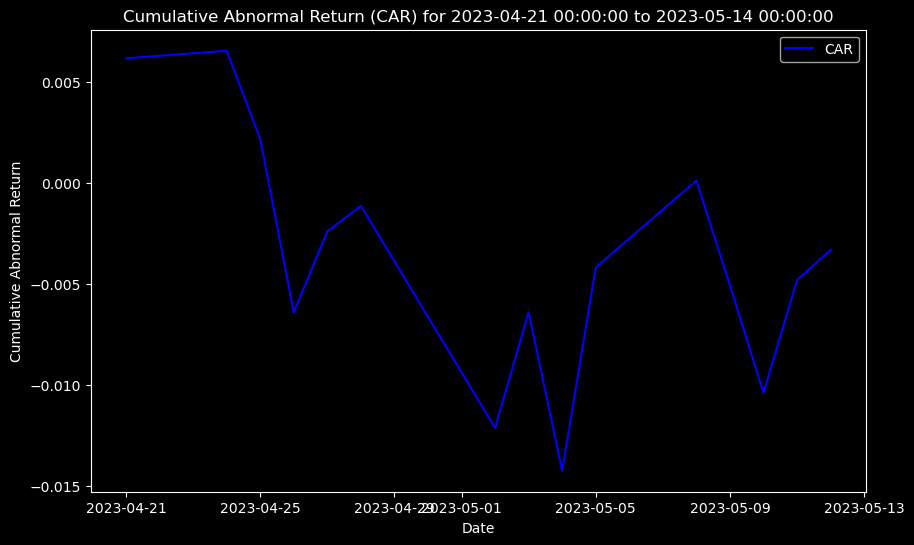


2023 Event: 2023-04-21 00:00:00 to 2023-05-14 00:00:00
Mean CAR: -0.0037, Std Dev: 0.0060
T-Statistic: -2.3815, CAR P-Value: 0.0320


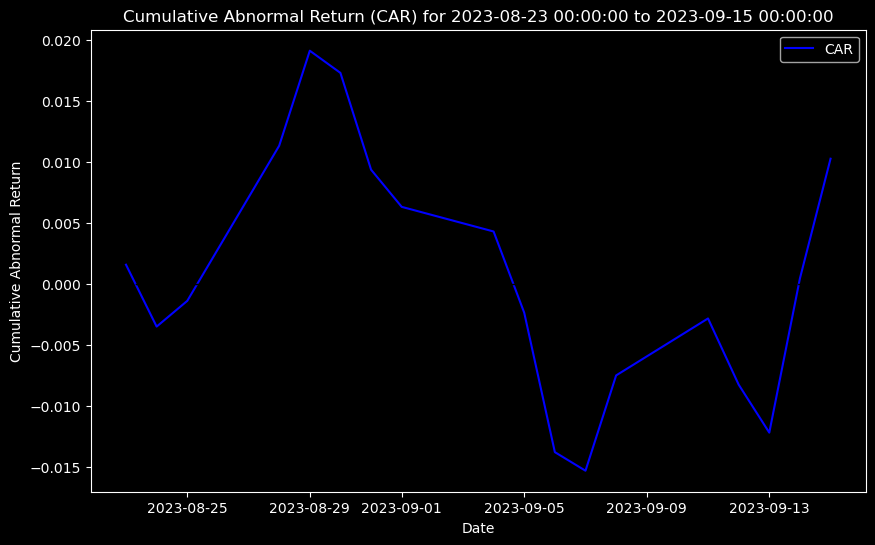


2023 Event: 2023-08-23 00:00:00 to 2023-09-15 00:00:00
Mean CAR: 0.0007, Std Dev: 0.0102
T-Statistic: 0.2894, CAR P-Value: 0.7758


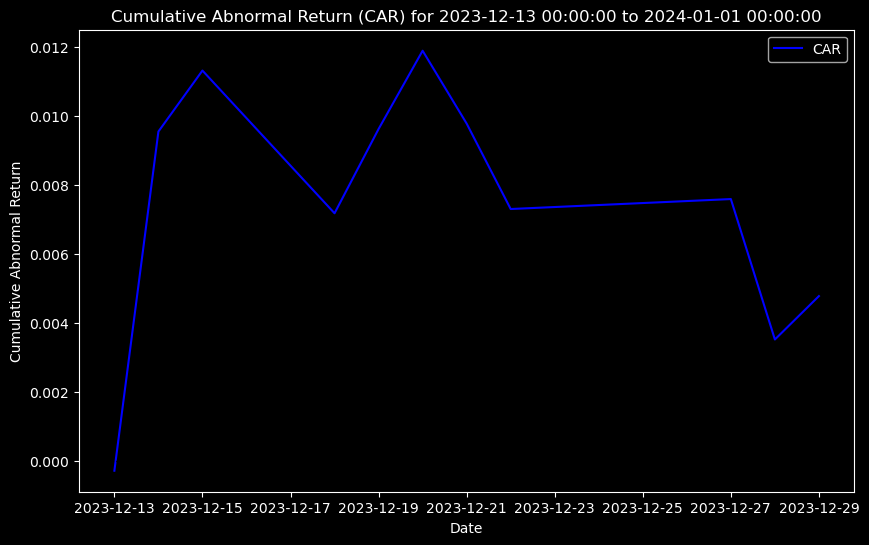


2023 Event: 2023-12-13 00:00:00 to 2024-01-01 00:00:00
Mean CAR: 0.0075, Std Dev: 0.0036
T-Statistic: 6.8401, CAR P-Value: 0.0000

2023 Variance Comparison
Event Variance: 0.0000, Non-Event Variance: 0.0001
Variance Difference (Event - Non-Event): -0.0000
F-Statistic for Variance Comparison: 0.4593, Variance P-Value: 0.0015



In [203]:
def calculate_abnormal_returns_and_compare_variance(df, event_periods,significance_level=0.):
    abnormal_returns = {}
    significant_years_count = 0
    for year, periods in event_periods.items():
        yearly_data = df[df.index.year == int(year)].copy()  
        if yearly_data['Return'].isnull().any():
            print(f"Missing values detected in {year}, consider handling them before fitting the model.")
            continue
        auto_model = auto_arima(yearly_data['Return'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        best_order = auto_model.order
        print(f"Best ARIMA order for {year}: {best_order}")
        best_arma_model = auto_model.fit(yearly_data['Return'])
        yearly_data['Normal_Return'] = best_arma_model.predict_in_sample()
        event_returns = []
        non_event_returns = yearly_data['Return'].tolist() 
        
        for start_date, end_date in periods:
            event_window = yearly_data[start_date:end_date].copy()  
            event_window['Abnormal_Return'] = event_window['Return'] - event_window['Normal_Return']
            event_window['CAR'] = event_window['Abnormal_Return'].cumsum()
            event_returns.extend(event_window['Return'].tolist())
            non_event_returns = [ret for ret, date in zip(non_event_returns, yearly_data.index) if date not in event_window.index]
            abnormal_returns[(year, start_date, end_date)] = event_window[['Return', 'Normal_Return', 'Abnormal_Return', 'CAR']]
            plt.figure(figsize=(10, 6))
            plt.plot(event_window.index, event_window['CAR'], label='CAR', color='blue')
            plt.axhline(0, color='black', linestyle='--', linewidth=1)
            plt.title(f'Cumulative Abnormal Return (CAR) for {start_date} to {end_date}')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Abnormal Return')
            plt.legend()
            plt.show()
            
            # Test significance (t-test of CAR against 0)
            car_mean = event_window['CAR'].mean()
            car_std = event_window['CAR'].std()
            t_stat, car_p_value = stats.ttest_1samp(event_window['CAR'], 0)
            
            print(f"\n{year} Event: {start_date} to {end_date}")
            print(f"Mean CAR: {car_mean:.4f}, Std Dev: {car_std:.4f}")
            print(f"T-Statistic: {t_stat:.4f}, CAR P-Value: {car_p_value:.4f}")

        # Calculate variances of event and non-event returns
        event_variance = pd.Series(event_returns).var()
        non_event_variance = pd.Series(non_event_returns).var()
        variance_difference = event_variance - non_event_variance
        
        # Conduct F-test to compare variances
        f_stat = event_variance / non_event_variance
        df1, df2 = len(event_returns) - 1, len(non_event_returns) - 1
        p_value = stats.f.cdf(f_stat, df1, df2)
        
        print(f"\n{year} Variance Comparison")
        print(f"Event Variance: {event_variance:.4f}, Non-Event Variance: {non_event_variance:.4f}")
        print(f"Variance Difference (Event - Non-Event): {variance_difference:.4f}")
        print(f"F-Statistic for Variance Comparison: {f_stat:.4f}, Variance P-Value: {p_value:.4f}\n")

# Execute the function
abnormal_returns = calculate_abnormal_returns_and_compare_variance(df, event_periods)

In [ ]:
def calculate_and_plot_car_histogram(df, event_periods):
    car_values = []  # To store CAR values for each event period
    car_labels = []  # To label each bar with the year and start date only
    positive_abnormal_returns = 0  # Count of positive abnormal returns
    negative_abnormal_returns = 0  # Count of negative abnormal returns
    total_abnormal_returns = 0  # Total abnormal returns counted
    
    for year, periods in event_periods.items():
        # Select data for the year
        yearly_data = df[df.index.year == int(year)].copy()
        
        # Check for missing values
        if yearly_data['Return'].isnull().any():
            print(f"Missing values detected in {year}, consider handling them before fitting the model.")
            continue
        
        # Find the best ARIMA model parameters using auto_arima
        auto_model = auto_arima(yearly_data['Return'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        best_order = auto_model.order
        print(f"Best ARIMA order for {year}: {best_order}")
        
        # Fit ARIMA model with the selected best order
        best_arma_model = auto_model.fit(yearly_data['Return'])
        yearly_data['Normal_Return'] = best_arma_model.predict_in_sample()
        
        for start_date, end_date in periods:
            # Slice event window data
            event_window = yearly_data[start_date:end_date].copy()
            
            # Calculate abnormal returns and cumulative abnormal return (CAR)
            event_window['Abnormal_Return'] = event_window['Return'] - event_window['Normal_Return']
            car = event_window['Abnormal_Return'].cumsum().iloc[-1]  # Last value of cumulative sum as total CAR
            
            # Count positive and negative abnormal returns
            positive_abnormal_returns += (event_window['Abnormal_Return'] > 0).sum()
            negative_abnormal_returns += (event_window['Abnormal_Return'] < 0).sum()
            total_abnormal_returns += len(event_window)
            
            # Store CAR and label (using only year and start date)
            car_values.append(car)
            car_labels.append(f'{year}-{start_date.date()}')  # Format as YYYY-MM-DD
            
    # Calculate the percentages of positive and negative abnormal returns
    positive_percentage = (positive_abnormal_returns / total_abnormal_returns) * 100
    negative_percentage = (negative_abnormal_returns / total_abnormal_returns) * 100
    
    # Print the percentages
    print(f"\nPercentage of Positive Abnormal Returns: {positive_percentage:.2f}%")
    print(f"Percentage of Negative Abnormal Returns: {negative_percentage:.2f}%")
    
    # Plot histogram of CAR values
    plt.figure(figsize=(12, 8))
    plt.bar(car_labels, car_values, color='skyblue')
    
    # Adjust x-ticks to show only the date (YYYY-MM-DD)
    plt.xticks(rotation=90)
    plt.xlabel('Event Start Date (YYYY-MM-DD)')
    plt.ylabel('Cumulative Abnormal Return (CAR)')
    plt.title('Cumulative Abnormal Returns (CAR) - China')
    plt.tight_layout()  # Ensures labels fit nicely
    plt.show()

# Execute the function
calculate_and_plot_car_histogram(df, event_periods)
